In [6]:
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from datetime import date
import datetime
import csv
import baltic as bt
import collections
# from Bio.Alphabet import IUPAC
# from pySankey.sankey import sankey
import math
import collections
import datetime as dt

import os
import csv
from Bio import SeqIO
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import collections
import numpy as np
import pandas as pd
import datetime
from datetime import date
# import skbio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import matplotlib.lines as mlines
import collections
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.collections import PatchCollection
from epiweeks import Week, Year
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 18}
from matplotlib.lines import Line2D

mpl.rcParams.update({'font.size': 18})

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [7]:

    
def get_node_states_all_sites(directory,state_file,alignment):
    
    #returns a dict keys off 1-based positions in the genome
    #and the value is a list of tuples (id, base) at a given node
    # allows you to look up for a given site what the base is for a
    #given internal node or tip
    
    node_states = collections.defaultdict(list)
    c = 0
    
    ## first the reconstructed nodes
    with open(f"{directory}/{state_file}","r") as f:
        for l in f:

            if not l.startswith("#"):
                c+=1
                try:
                    node,site,state,probA,probC,probG,probT = l.rstrip("\n").split("\t")
                except:
                    print(l)
                    break
                if node != "Node":
                    if state not in ["N","-"]:
                        node_states[site].append((node,state))
                    else:
                        node_states[site].append((node,""))
    ## now the tips
    for record in SeqIO.parse(f"{directory}/{alignment}","fasta"):
        for site in node_states:
            index = int(site)-1
            base = record.seq[index]
            if base in ["T","C","A","G"]:
                node_states[site].append((record.id,base))
            else:
                node_states[site].append((record.id,""))
                
    return node_states

def get_header_str(dict_values):
    header_str = ""
    for i in sorted(dict_values, key = lambda i : i[0]):
        header_str += f"{i[0]},"
    header_str = header_str.rstrip(",")
    return header_str
    
    
def find_what_sites_vary_unambiguously(node_states,outfile):
    header_str = get_header_str(node_states["1"])
    
    with open(outfile,"w") as fw:
        fw.write(f"site,{header_str}\n")

        for site in node_states:
            info = node_states[site]
            
            # get the set of unique bases at a given site
            count = set([i[1] for i in info if i[1]])
            
            #if there's more than one
            if len(count)>1:
                
                #needs to be kep consistent with header str
                info = sorted(info, key = lambda i : i[0])
                base_str = ""
                for i in info:
                    base_str += f"{i[1]},"
                    
                base_str = base_str.rstrip(",")
                fw.write(f"{site},{base_str}\n")
    
def load_unambiguous_varying_sites(infile):
    node_states_diff = collections.defaultdict(dict)
    with open(infile,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            site = row["site"]
            for col in row:
                if col != "site":
                    node_states_diff[row["site"]][col] = row[col]
    return node_states_diff

def map_site_changes_to_branches(treefile, outfile,node_states,node_states_diff): 
    my_tree=bt.loadNewick(treefile,absoluteTime=False)
    last_node = ""
    current_node = ""

    with open(outfile,"w") as fw:
        fw.write("parent,child,site,snp,dimer\n")

        for k in my_tree.Objects:
            if k.branchType == 'leaf':
                current_node = k
                current_node.traits["label"]=k.name
            else:
                current_node = k

            if last_node:
                node_name = current_node.traits["label"]
                parent_name = current_node.parent.traits["label"]
                snps = []
                for site in node_states_diff:
                    node_base = node_states_diff[site][node_name]
                    parent_base = node_states_diff[site][parent_name]

                    if node_base != parent_base:
                        if node_base in ["A","C","G","T"] and parent_base in ["A","C","G","T"]:
                            snp = f"{parent_base}->{node_base}"
                            snps.append(snp)
                            if snp == "G->A":
                                dimer_site = f"{int(site)+1}"
                                dimer_base = ""

                                for i in node_states[dimer_site]:
                                    if i[0] == parent_name:
                                        dimer_base = i[1]
                                dimer = f"{parent_base}{dimer_base}"
                            elif snp == "C->T":
                                dimer_site = f"{int(site)-1}"
                                dimer_base = ""

                                for i in node_states[dimer_site]:
                                    if i[0] == parent_name:
                                        dimer_base = i[1]
                                dimer = f"{dimer_base}{parent_base}"
                            else:
                                dimer = ""
                            fw.write(f"{parent_name},{node_name},{site},{snp},{dimer}\n")

            last_node = current_node

def read_in_branch_snps(branch_snps):
    branch_snps_dict = collections.defaultdict(list)
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            branch = f"{row['parent']}_{row['child']}"
            branch_snps_dict[branch].append((row['site'],row['snp'],row['dimer'])) 
    return branch_snps_dict

def get_branch_snps_sites(branch_snps):
    all_snps = collections.Counter()
    branch_snps_dict = collections.defaultdict(list)
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            all_snps[int(row["site"])]+=1

            branch_snps_dict[int(row['site'])].append([row['parent'],row['child'],row['snp'],row['dimer']])
    
    homoplasies = {}
    for k in all_snps:
        if all_snps[k]>1:
            homoplasies[k] = all_snps[k]
            
    print(len(homoplasies))
    print(homoplasies)
    return branch_snps_dict,homoplasies
    

def get_acc_to_metadata_map(metadata):
    acc_dict = {}
    with open(metadata,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                acc_dict[row["accession"]] = row
            except:
                try:
                    acc_dict[row["\ufeffaccession"]] = row
                except:
                    pass
                
    return acc_dict

def make_reconstruction_tree_figure(outfile,branch_snps,treefile,width,height):
    
    branch_snps_dict = read_in_branch_snps(branch_snps)
    print(len(branch_snps_dict),"snps")
#     acc_dict = get_acc_to_metadata_map(metadata)
#     print(len(acc_dict))        
    
    my_tree=bt.loadNewick(treefile,absoluteTime=False)

    fig,ax = plt.subplots(figsize=(width,height),facecolor='w')

    x_attr=lambda k: k.height ## x coordinate of branches will be absoluteTime attribute
    su_func=lambda k: 50-30*k.height/my_tree.treeHeight ## size of tips
    s_func=lambda k: 50-20*k.height/my_tree.treeHeight ## size of tips
    c_func=lambda k: "dimgrey"

    increment = my_tree.treeHeight/150
    my_tree.plotTree(ax,x_attr=x_attr) ## plot branches
    my_tree.plotPoints(ax,size=s_func,colour=c_func,x_attr=x_attr) ## plot circles at tips
    mpl.rcParams['font.family'] = 'sans-serif'

    for k in my_tree.Objects:
        current_node = k
        if k.branchType == 'leaf':
            current_node.traits["label"]=k.name

        node_name = current_node.traits["label"]
        try:
            parent_name = current_node.parent.traits["label"]
        except:
            continue
        branch_name= f"{parent_name}_{node_name}"

        if branch_name in branch_snps_dict:
            snps = []
#                 print(branch_name, len(branch_snps_dict[branch_name]))
            snp_placement = current_node.parent.height + increment
            for s in branch_snps_dict[branch_name]:
                site,snp,dimer = s
                if snp == "G->A":
                    if dimer in ["GA"]:
                        snps.append((1,"#995e62"))
                    else:
                        snps.append((2,"#d9b660"))
                elif snp == "C->T":
                    if dimer in ["TC"]:
                        snps.append((1,"#995e62"))
                    else:
                        snps.append((2,"#d9b660"))
                else:
                    snps.append((2,"#d9b660"))

            for snp in sorted(snps, key = lambda x : x[0]):
                plt.scatter([snp_placement],[k.y+0.5],color=snp[1],s=30)
                snp_placement += increment

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(axis='y',size=0)
    ax.tick_params(axis='x',size=0)

    ax.set_yticklabels([])
    ax.set_xticklabels([])

    plt.savefig(f"figures/{outfile}.svg");
    plt.savefig(f"figures/{outfile}.png",bbox_inches='tight', 
                   transparent=True);
    plt.show()
    

def make_reconstruction_tree_figure_w_labels(outfile,branch_snps,treefile,width,height):
    
    branch_snps_dict = read_in_branch_snps(branch_snps)
    print(len(branch_snps_dict),"branches")
#     acc_dict = get_acc_to_metadata_map(metadata)
#     print(len(acc_dict))        
    
    my_tree=bt.loadNewick(treefile,absoluteTime=False)

    fig,ax = plt.subplots(figsize=(width,height),facecolor='w')

    x_attr=lambda k: k.height ## x coordinate of branches will be absoluteTime attribute
    su_func=lambda k: 50-30*k.height/my_tree.treeHeight ## size of tips
    s_func=lambda k: 50-20*k.height/my_tree.treeHeight ## size of tips
    c_func=lambda k: "dimgrey"

    increment = my_tree.treeHeight/150
    my_tree.plotTree(ax,x_attr=x_attr) ## plot branches
    my_tree.plotPoints(ax,size=s_func,colour=c_func,x_attr=x_attr) ## plot circles at tips
    mpl.rcParams['font.family'] = 'sans-serif'

    for k in my_tree.Objects:
        current_node = k
        if k.branchType == 'leaf':
            current_node.traits["label"]=k.name

        node_name = current_node.traits["label"]
        try:
            parent_name = current_node.parent.traits["label"]
        except:
            continue
        branch_name= f"{parent_name}_{node_name}"

        if branch_name in branch_snps_dict:
            snps = []
#                 print(branch_name, len(branch_snps_dict[branch_name]))
            snp_placement = current_node.parent.height + increment
            for s in branch_snps_dict[branch_name]:
                site,snp,dimer = s
                if snp == "G->A":
                    if dimer in ["GA"]:
                        snps.append((1,"orange"))
                    else:
                        snps.append((3,"lightseagreen"))
                elif snp == "C->T":
                    if dimer in ["TC"]:
                        snps.append((2,"blue"))
                    else:
                        snps.append((3,"lightseagreen"))
                else:
                    snps.append((4,"dimgrey"))

            for snp in sorted(snps, key = lambda x : x[0]):
                plt.scatter([snp_placement],[k.y+0.5],color=snp[1],s=30)
                snp_placement += increment

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(axis='y',size=0)
    ax.tick_params(axis='x',size=0)

    ax.set_yticklabels([])
    ax.set_xticklabels([])

    plt.savefig(f"figures/{outfile}.svg");
    plt.savefig(f"figures/{outfile}.png",bbox_inches='tight', 
                   transparent=True);
    plt.show()
    
def generate_reconstruction_files(directory, alignment,treefile):
    
    node_states = get_node_states_all_sites(directory,f"{alignment}.state",alignment)
        
    find_what_sites_vary_unambiguously(node_states,f"{directory}/{treefile}.state_differences.csv")
    
def load_info(directory, alignment,treefile,treefigureout,width=25,height=30):
    node_states = get_node_states_all_sites(directory,f"{alignment}.state",alignment)
    node_states_diff = load_unambiguous_varying_sites(f"{directory}/{treefile}.state_differences.csv")

    map_site_changes_to_branches(f"{directory}/{treefile}",
                                 f"{directory}/{treefile}.branch_snps.reconstruction.csv",
                                 node_states,
                                 node_states_diff)

    make_reconstruction_tree_figure(treefigureout,
                                    f"{directory}/{treefile}.branch_snps.reconstruction.csv",
                                    f"{directory}/{treefile}",width,height)
    
def make_apobec_context_mutation_count_plot(branch_snps,out_counts,outfigure):
    type_counter = collections.Counter()
    apobec_counter = collections.Counter()
    all_snps_count = 0
    all_apobec_count = 0
    with open(branch_snps,"r") as f:
        
        reader = csv.DictReader(f)
        for row in reader:
#             print(row)
            if row["parent"] != "Node1":
                if row["dimer"] in ["TC","GA"]:

                    apobec_counter[f'{row["snp"]}']+=1
                    all_apobec_count +=1

                type_counter[f'{row["snp"]}']+=1
                all_snps_count +=1
                
    print(all_snps_count, all_apobec_count, all_apobec_count/all_snps_count)  
    with open(out_counts,"w") as fw:
        fw.write("snp,count,target\n")            
        for i in sorted(type_counter, key=lambda x : type_counter[x], reverse=True):
            if i in apobec_counter:
                fw.write(f"{i},{type_counter[i]},{apobec_counter[i]}\n")
            else:
                fw.write(f"{i},{type_counter[i]},0\n")
    
    df = pd.read_csv(out_counts)
    fig,ax= plt.subplots(figsize=(6,4),facecolor='w',frameon=False)

    sns.barplot(x = 'snp', y = 'count', data = df, color = 'dimgrey',alpha=0.4)

    sns.barplot(x = 'snp', y = 'target', data = df, color = 'steelblue',alpha=0.6)

    [ax.spines[loc].set_visible(False) for loc in ['top','right']]
    plt.xlabel("SNP")
    plt.ylabel("Count")

    plt.savefig(f"figures/{outfigure}.svg");
    plt.savefig(f"figures/{outfigure}.png",bbox_inches='tight', 
                   transparent=True);

    plt.show();

def make_apobec_context_internal_plot(branch_snps,out_counts,outfigure):
    type_counter = collections.Counter()
    apobec_counter = collections.Counter()
    all_snps_count = 0
    all_apobec_count = 0
    with open(branch_snps,"r") as f:
        
        reader = csv.DictReader(f)
        for row in reader:
#             print(row)
            if row["child"].startswith("Node") and row["parent"] != "Node1":
                if row["dimer"] in ["TC","GA"]:

                    apobec_counter[f'{row["snp"]}']+=1
                    all_apobec_count +=1

                type_counter[f'{row["snp"]}']+=1
                all_snps_count +=1
                
    print(all_snps_count, all_apobec_count, all_apobec_count/all_snps_count)  
    with open(out_counts,"w") as fw:
        fw.write("snp,count,target\n")            
        for i in sorted(type_counter, key=lambda x : type_counter[x], reverse=True):
            if i in apobec_counter:
                snp = i.replace("->","")
                fw.write(f"{snp},{type_counter[i]},{apobec_counter[i]}\n")
            else:
                snp = i.replace("->","")
                fw.write(f"{snp},{type_counter[i]},0\n")
    
    df = pd.read_csv(out_counts)
    fig,ax= plt.subplots(figsize=(8,4),facecolor='w',frameon=False)

    sns.barplot(x = 'snp', y = 'count', data = df, color = 'dimgrey',alpha=0.4)

    sns.barplot(x = 'snp', y = 'target', data = df, color = 'steelblue',alpha=0.6)

    [ax.spines[loc].set_visible(False) for loc in ['top','right']]
    plt.xlabel("SNP")
    plt.ylabel("Count")

    plt.savefig(f"figures/{outfigure}.svg");
    plt.savefig(f"figures/{outfigure}.png",bbox_inches='tight', 
                   transparent=True);

    plt.show();
    
    
def make_apobec_context_external_plot(branch_snps,out_counts,outfigure):
    type_counter = collections.Counter()
    apobec_counter = collections.Counter()
    all_snps_count = 0
    all_apobec_count = 0
    with open(branch_snps,"r") as f:
        
        reader = csv.DictReader(f)
        for row in reader:
#             print(row)
            if not row["child"].startswith("Node") and row["parent"] != "Node1":
                if row["dimer"] in ["TC","GA"]:

                    apobec_counter[f'{row["snp"]}']+=1
                    all_apobec_count +=1

                type_counter[f'{row["snp"]}']+=1
                all_snps_count +=1
                
    print(all_snps_count, all_apobec_count, all_apobec_count/all_snps_count)  
    with open(out_counts,"w") as fw:
        fw.write("snp,count,target\n")            
        for i in sorted(type_counter, key=lambda x : type_counter[x], reverse=True):
            if i in apobec_counter:
                fw.write(f"{i},{type_counter[i]},{apobec_counter[i]}\n")
            else:
                fw.write(f"{i},{type_counter[i]},0\n")
    
    df = pd.read_csv(out_counts)
    fig,ax= plt.subplots(figsize=(12,4),facecolor='w',frameon=False)

    sns.barplot(x = 'snp', y = 'count', data = df, color = 'dimgrey',alpha=0.4)

    sns.barplot(x = 'snp', y = 'target', data = df, color = 'steelblue',alpha=0.6)

    [ax.spines[loc].set_visible(False) for loc in ['top','right']]
    plt.xlabel("SNP")
    plt.ylabel("Count")

    plt.savefig(f"figures/{outfigure}.svg");
    plt.savefig(f"figures/{outfigure}.png",bbox_inches='tight', 
                   transparent=True);

    plt.show();
    
def get_aa_position(index,based=0):
    if based != 0:
        index -= based 

    remainder = index%3
    position_dict = {1:2,2:3,0:1}
    
    return position_dict[remainder]

def reverse_aa_position(start,end,site):
    index_dict = {}
    index = 0
    rev_position_dict = {1:2,2:3,0:1}
    for i in reversed(range(start,end)):
        remainder = index%3
        index_dict[i] = rev_position_dict[remainder]
        index +=1 

    position = index_dict[site]
    
    return position

def get_codon_indexes(aa_position,index):
    codon = []
    if aa_position == 1:
        codon = [index,index+1,index+2]
    elif aa_position == 2:
        codon = [index-1,index,index+1]
    elif aa_position == 3:
        codon =  [index-2,index-1,index]
    else:
        print("incorrect aa position")
        
    return codon

def get_codon_indexes_rev_strand(position,index):
    codon = []
    if position == 3:
        codon = [index,index+1,index+2]
    elif position == 2:
        codon = [index-1,index,index+1]
    elif position == 1:
        codon =  [index-2,index-1,index]
    return codon


def get_gene_boundaries():
    genes = {}
    gene_id = 0
    with open("/Users/s1680070/repositories/alignHPXV/squirrel/data/gene_boundaries.csv","r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            gene_id +=1
            name = f"{row['Name'].replace(' ','_')}_{gene_id}"
            start = int(row["Minimum"]) - 1
            end = int(row["Maximum"])
            length = int(row["Length"])
            direction = row["Direction"]
            genes[(start,end)]=(name,length,direction)
    return genes

def get_grantham_scores():
    grantham_scores = {}

    with open("metadata/grantham_score.txt","r") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            for col in row:
                if col!="FIRST":
                    mutation = f"{row['FIRST']}{col}"

                    if row[col] != "0":
                        grantham_scores[mutation] = int(row[col])                    
                        grantham_scores[mutation[::-1]] = int(row[col])
    return grantham_scores
 
    
def categorise_amino_acid_mutation(aa1,aa2,grantham_scores):
    
    mutation_category = ""
    if aa1 == aa2:
        mutation_category = "synonymous"
    else:
        if aa2 == '*':
            mutation_category = "nonsense"
        else:
            mutation_category = "nonsynonymous"

    if f"{aa1}{aa2}" in grantham_scores:
        score = grantham_scores[f"{aa1}{aa2}"]
        if score < 51:
            prediction = "conservative"
        elif score <101:
            prediction = "moderately conservative"
        elif score <151:
            prediction = "moderately radical"
        else:
            prediction = "radical"
    else:
        score = "NA"
        prediction = "NA"
    
    return mutation_category,score,prediction

def reconstruct_amino_acid_mutations(branch_snps,node_states,outfile):
    branch_snps_dict,homoplasies = get_branch_snps_sites(branch_snps)
    genes = get_gene_boundaries()
    grantham_scores = get_grantham_scores()
    
    fw = open(outfile,"w")
    fw.write("site,gene,direction,snp,dimer,apobec,aa_position,parent,parent_codon,parent_aa,")
    fw.write("child,child_codon,child_aa,mutation_category,score,prediction,homoplasy,occurrence\n")
    
    for site in branch_snps_dict:
        
        homoplasy = "False"
        occurrence = "1"
        if site in homoplasies:
            homoplasy = "True"
            occurrence = f"{homoplasies[site]}"
        site_found = False
        for gene in genes:
            start,end=gene

            if site in range(start,end):
                
                site_found = True
                name,length,direction = genes[gene]
                for site_snp in branch_snps_dict[site]:
                    parent,child,snp,dimer = site_snp

                    if direction == "forward":
                        aa_position = get_aa_position(site,gene[0])
                        codon_indexes = get_codon_indexes(aa_position,site)
                    else:
                        aa_position = reverse_aa_position(start,end,site)
                        codon_indexes = get_codon_indexes_rev_strand(aa_position,site)

                    parent_codon = []
                    child_codon = []

                    for base in codon_indexes:
                        reconstruction = node_states[f"{base}"]
                        for node in reconstruction:
                            if node[0] == parent:
                                parent_codon.append(node[1])

                            elif node[0] == child:
                                child_codon.append(node[1])

                    parent_codon = "".join(parent_codon)
                    child_codon = "".join(child_codon)

                    parent_codon = Seq(parent_codon)
                    child_codon = Seq(child_codon)

                    if direction == "reverse":
                        parent_codon= parent_codon.reverse_complement()
                        child_codon= child_codon.reverse_complement()

                    parent_aa = parent_codon.translate()
                    child_aa = child_codon.translate()

                    mutation_category,score,prediction = categorise_amino_acid_mutation(parent_aa,child_aa,grantham_scores)
                    apobec = "False"
                    if snp in ["C->T","G->A"] and dimer in ["GA","TC"]:
                        apobec = "True"

                    fw.write(f"{site},{name},{direction},{snp},{dimer},{apobec},{aa_position},{parent},{parent_codon},{parent_aa},{child},{child_codon},{child_aa},{mutation_category},{score},{prediction},{homoplasy},{occurrence}\n")                                    
        
        if not site_found:
            for snp_site in branch_snps_dict[site]:
                parent,child,snp,dimer = snp_site
                apobec = "False"
                if snp in ["C->T","G->A"] and dimer in ["GA","TC"]:
                    apobec = "True"
                fw.write(f"{site},NA,NA,{snp},{dimer},{apobec},NA,{parent},NA,NA,{child},NA,NA,intergenic,NA,NA,{homoplasy},{occurrence}\n")                                    
            
    fw.close()
            
        
def get_reconstruction_amino_acids(directory,alignment,treefile):
    node_states = get_node_states_all_sites(directory,f"{alignment}.state",alignment)
    print("Node states",len(node_states))
    branch_snps = f"{directory}/{treefile}.branch_snps.reconstruction.csv"

    reconstruct_amino_acid_mutations(f"{branch_snps}",
                                    node_states, 
                                     f"{directory}/{treefile}.amino_acid.reconstruction.csv")
    
    
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

def get_root_to_tip_counts(aa_reconstruction,state_diffs,APO_out,root_to_tip_counts):

    site_info = {}
    with open(aa_reconstruction,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            site_info[row["site"]] = row

    # for i in site_info:
    #     print(i, site_info[i])

    seq_snps = collections.defaultdict(list)
    apobec_snps = collections.defaultdict(list)
    non_apo = collections.defaultdict(list)
    with open(state_diffs,"r") as f:
        reader = csv.DictReader(f)

        for row in reader:
            root_variant = row["Node1"]

            for seq in reader.fieldnames:
                if seq != "site" and not seq.startswith("Node"):
                    if row[seq] != root_variant:
                        if "" not in [row[seq],root_variant]:
                            try:
                                snp_info = site_info[row["site"]]
                                if snp_info["apobec"] == "True":
                                    apobec_snps[seq].append(row["site"])
                                else:
                                    non_apo[seq].append(row["site"])
                                seq_snps[seq].append(row["site"])
                            except:
                                pass
    s = []
    date_apo = {}
    fw2 = open(APO_out,"w")
    fw2.write("name,date\n")
    with open(root_to_tip_counts,"w") as fw:
        fw.write("name,all_snps,apobec_snps,non_apobec_snps,date,decimal_year,precision\n")
        for i in seq_snps:
            datestring = i.split("|")[-1]
            
            precision = ""
            
            if len(datestring.split("-")) == 3:
                ddate = date.fromisoformat(datestring)
                odate = year_fraction(ddate)
                
                precision = "day"
                print(datestring,odate,precision)
            elif len(datestring.split("-")) == 2:
                if datestring.endswith("-2"):
                    datestring+="-15"
                else:
                    datestring+="-16"
                ddate = date.fromisoformat(datestring)
                odate = year_fraction(ddate)
                
                precision = "month"
                print(datestring,odate,precision)
            else:
                
                odate = float(datestring)+0.5
                precision="year"
                print(datestring,odate,precision)
            if i in apobec_snps:
                if i in non_apo:
                    fw.write(f"{i},{len(seq_snps[i])},{len(apobec_snps[i])},{len(non_apo[i])},{datestring},{odate},{precision}\n")
                else:
                    fw.write(f"{i},{len(seq_snps[i])},{len(apobec_snps[i])},0,{datestring},{odate},{precision}\n")
                date_apo[i] = [apobec_snps[i],datestring]
            else:
                if i in non_apo:
                    fw.write(f"{i},{len(seq_snps[i])},0,{len(non_apo[i])},{datestring},{odate},{precision}\n")
                else:
                    fw.write(f"{i},{len(seq_snps[i])},0,0,{datestring},{odate},{precision}\n")

#             else:
#                 print(date)


def get_heptamers_internal(node_states,branch_snps):
    site_dict = collections.defaultdict(list)
    snp_count = 0
    apo_snp_count =0
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            
            if row["child"].startswith("Node") and row["parent"] != "Node1":
                snp_count +=1
                if row["snp"] in ["G->A","C->T"]:
                    apo_snp_count +=1
                    site_dict[row["site"]] = (row["parent"],row["snp"])
                    
    print(snp_count, apo_snp_count)
    heptamers = []
    for site in site_dict:
        
        parent,dimer = site_dict[site]
#         print(site, parent, dimer)
        site = int(site)
        indexes = []
        bases = []
        for i in range(site-3,site+4):
            indexes.append(i)
            nodes = node_states[f"{i}"]
            base = ""
            for node in nodes:
                if node[0] == parent:
                    base = node[1]
            bases.append(base)
        seq = "".join(bases)
        
        seq = Seq(seq)
        
        if dimer == "G->A":
            
            seq = seq.reverse_complement()
        
        heptamers.append(seq)
    return snp_count,heptamers
            
def get_heptamers_all(node_states,branch_snps):
    site_dict = collections.defaultdict(list)
    snp_count = 0
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            snp_count +=1
            if row["snp"] in ["G->A","C->T"]:
                site_dict[row["site"]] = (row["parent"],row["snp"])
    heptamers = []
    for site in site_dict:
        
        parent,dimer = site_dict[site]
#         print(site, parent, dimer)
        site = int(site)
        indexes = []
        bases = []
        for i in range(site-3,site+4):
            indexes.append(i)
            nodes = node_states[f"{i}"]
            base = ""
            for node in nodes:
                if node[0] == parent:
                    base = node[1]
            bases.append(base)
        seq = "".join(bases)
        
        seq = Seq(seq)
        
        if dimer == "G->A":
            
            seq = seq.reverse_complement()
        
        heptamers.append(seq)
    return snp_count,heptamers

def make_heptamer_figure(heptamers,hept_out,heptfigure):
    hept_dict = {}
    for i in range(7):
        hept_dict[i] = collections.Counter()

    rel_dict = {0:-3,1:-2,2:-1,3:0,4:1,5:2,6:3}
    mutations = 0

    with open(hept_out,"w") as fw:
        fw.write("position,rel_position,base\n")
        for heptamer in heptamers:
            hept_list = list(heptamer)

            for i in range(len(hept_list)):
                hept_dict[i][hept_list[i]] +=1 
                fw.write(f"{i+1},{rel_dict[i]},{hept_list[i]}\n")
                
#             for i in hept_dict:
#                 print(i, hept_dict[i])
                        
    df = pd.read_csv(hept_out)
    df
    fig,ax= plt.subplots(figsize=(4,4),facecolor='w',frameon=False)
    colors = {"A":"#4682B4",
              "C":"indianred",
              "G":"#BC9D60",
              "T":"#87CEEB"}
    
    colors = ["#BC9D60","#87CEEB","#4682B4","indianred"]
    customPalette = sns.set_palette(sns.color_palette(colors))

#     legend_elements = [Line2D([0], [0], markerfacecolor='#4682B4',color='white',markersize=15,alpha=0.6, marker='o',label='A'),
#                        Line2D([0], [0], markerfacecolor='indianred',color='white',markersize=15,alpha=0.6, marker='o',label='C'),
#                        Line2D([0], [0], markerfacecolor='#BC9D60',color='white',markersize=15, alpha=0.6,marker='o',label='G'),
#                         Line2D([0], [0], markerfacecolor='#87CEEB',color='white',markersize=15,alpha=0.6, marker='o',label='T')]

    g = sns.histplot(data=df, x="rel_position",hue="base",multiple="fill",hue_order = ['A','C','G','T'],palette=customPalette,alpha=0.6,bins=7,linewidth=1)

    sns.move_legend(ax, "center", bbox_to_anchor=(1, 1), frameon=False,title="")
    plt.xlim(-3,3)

    plt.xlabel("Position\n");
    plt.ylabel("Proportion")
    [ax.spines[loc].set_visible(False) for loc in ['top','right']]

    plt.savefig(f"figures/{heptfigure}.svg");
    plt.savefig(f"figures/{heptfigure}.png",bbox_inches='tight', 
                   transparent=True);
    plt.show();
    
def get_reconstruction_heptamers(directory, alignment,treefile,hept_out,heptamer_figure,width=35):
    node_states = get_node_states_all_sites(directory,f"{alignment}.state",alignment)
    print("Node states",len(node_states))
    branch_snps = f"{directory}/{treefile}.branch_snps.reconstruction.csv"
    snp_count,heptamers = get_heptamers_all(node_states,branch_snps)

#     snp_count,heptamers = get_heptamers_internal(node_states,branch_snps)
    print("SNP count:",snp_count)
    print("Heptamer count:",len(heptamers))
    hept_out = f"{directory}/{hept_out}"
    hept_figure = f"{heptamer_figure}"

    make_heptamer_figure(heptamers,hept_out,hept_figure)
    
    

def get_reconstruction_internal_heptamers(directory, alignment,treefile,hept_out,heptamer_figure,width=35):
    node_states = get_node_states_all_sites(directory,f"{alignment}.state",alignment)
    print("Node states",len(node_states))
    branch_snps = f"{directory}/{treefile}.branch_snps.reconstruction.csv"
#     snp_count,heptamers = get_heptamers_all(node_states,branch_snps)

    snp_count,heptamers = get_heptamers_internal(node_states,branch_snps)
    print("SNP count:",snp_count)
    print("Heptamer count:",len(heptamers))
    hept_out = f"{directory}/{hept_out}"
    hept_figure = f"{heptamer_figure}"
    make_heptamer_figure(heptamers,hept_out,hept_figure)


In [8]:

def make_non_syn_tree_fig(outfile,branch_snps,treefile,width,height):
    
    branch_snps_dict = read_in_branch_snps(branch_snps)
    print(len(branch_snps_dict),"branches")
#     acc_dict = get_acc_to_metadata_map(metadata)
#     print(len(acc_dict))        
    
    my_tree=bt.loadNewick(treefile,absoluteTime=False)

    fig,ax = plt.subplots(figsize=(width,height),facecolor='w')

    x_attr=lambda k: k.height ## x coordinate of branches will be absoluteTime attribute
    su_func=lambda k: 50-30*k.height/my_tree.treeHeight ## size of tips
    s_func=lambda k: 50-20*k.height/my_tree.treeHeight ## size of tips
    c_func=lambda k: "dimgrey"

    increment = my_tree.treeHeight/150
    my_tree.plotTree(ax,x_attr=x_attr) ## plot branches
    my_tree.plotPoints(ax,size=s_func,colour=c_func,x_attr=x_attr) ## plot circles at tips
    mpl.rcParams['font.family'] = 'sans-serif'

    for k in my_tree.Objects:
        current_node = k
        if k.branchType == 'leaf':
            current_node.traits["label"]=k.name

        node_name = current_node.traits["label"]
        try:
            parent_name = current_node.parent.traits["label"]
        except:
            continue
        branch_name= f"{parent_name}_{node_name}"

        if branch_name in branch_snps_dict:
            snps = []
#                 print(branch_name, len(branch_snps_dict[branch_name]))
            snp_placement = current_node.parent.height + increment
            for s in branch_snps_dict[branch_name]:
                site,snp,dimer = s
                if snp == "G->A":
                    if dimer in ["GA"]:
                        snps.append((1,"orange"))
                    else:
                        snps.append((3,"lightseagreen"))
                elif snp == "C->T":
                    if dimer in ["TC"]:
                        snps.append((2,"blue"))
                    else:
                        snps.append((3,"lightseagreen"))
                else:
                    snps.append((4,"dimgrey"))

            for snp in sorted(snps, key = lambda x : x[0]):
                plt.scatter([snp_placement],[k.y+0.5],color=snp[1],s=30)
                snp_placement += increment

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(axis='y',size=0)
    ax.tick_params(axis='x',size=0)

    ax.set_yticklabels([])
    ax.set_xticklabels([])

    plt.savefig(f"figures/{outfile}.svg");
    plt.savefig(f"figures/{outfile}.png",bbox_inches='tight', 
                   transparent=True);
    plt.show()

In [3]:
df

,site,gene,direction,snp,dimer,apobec,aa_position,parent,parent_codon,parent_aa,child,child_codon,child_aa,mutation_category,score,prediction
0,3450,OPG003_CDS_176,reverse,G->A,GA,True,2.0,Node1,TCA,S,Node2,TTA,L,nonsynonymous,145.0,moderately radical
1,3450,OPG003_CDS_176,reverse,A->G,NaN,False,2.0,Node14,TTA,L,MT250197|Singapore_2019|Singapore_ex_Nigeria|2...,TCA,S,nonsynonymous,145.0,moderately radical
2,8893,NaN,NaN,C->A,NaN,False,NaN,Node1,NaN,NaN,Node2,NaN,NaN,intergenic,NaN,NaN
3,18312,OPG031_CDS_165,reverse,G->A,GA,True,3.0,Node1,ATC,I,Node2,ATT,I,synonymous,NaN,NaN
4,19367,OPG034_CDS_164,reverse,C->T,TC,True,2.0,Node1,CGA,R,Node2,CAA,Q,nonsynonymous,43.0,conservative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,119718,OPG137_CDS_63,forward,T->C,NaN,False,1.0,Node1,TCA,S,KJ642617|Nigeria-SE-1971|Nigeria_Abie_State|19...,CCA,P,nonsynonymous,74.0,moderately conservative
407,129762,OPG151_CDS_49,forward,A->G,NaN,False,3.0,Node1,TGA,*,KJ642617|Nigeria-SE-1971|Nigeria_Abie_State|19...,TGG,W,nonsynonymous,NaN,NaN
408,149744,OPG175_CDS_29,forward,G->A,GT,False,1.0,Node1,GTG,V,KJ642617|Nigeria-SE-1971|Nigeria_Abie_State|19...,ATG,M,nonsynonymous,21.0,conservative
409,160174,NaN,NaN,G->T,NaN,False,NaN,Node1,NaN,NaN,KJ642617|Nigeria-SE-1971|Nigeria_Abie_State|19...,NaN,NaN,intergenic,NaN,NaN


In [31]:

def forward_amino_acid_mutations(type_site_dict,seq,type_counter):
    genes = get_gene_boundaries()
    grantham_scores = get_grantham_scores()
    
    
    for i in range(len(seq)):
        base_1 = seq[i-1]
        base_2 = seq[i]
        
        dimer = f"{base_1}{base_2}"
        edited = "false"
        if dimer in ["TC","GA"]:
            snp = ""
            site = ""
            parent = ""
            child = ""
            if dimer == "TC":
                snp = "C->T"
                site = i
                parent = "C"
                child = "T"
            else:
                snp = "G->A"
                site = i-1
                parent = "G"
                child = "A"
            
            site_found = False
            
            for gene in genes:
                start,end=gene
                if site_found == True:
                    break
                    
                if site in range(start,end):
                    
                    name,length,direction = genes[gene]
                    if direction == "forward":
                        aa_position = get_aa_position(site,gene[0])
                        codon_indexes = get_codon_indexes(aa_position,site)
                    else:
                        aa_position = reverse_aa_position(start,end,site)
                        codon_indexes = get_codon_indexes_rev_strand(aa_position,site)

                    parent_codon = []
                    child_codon = []
                    for i in codon_indexes:
                        if i == site:
                            child_codon.append(child)
                        else:
                            child_codon.append(seq[i])
                        parent_codon.append(seq[i])


                    parent_codon = "".join(parent_codon)
                    child_codon = "".join(child_codon)

                    parent_codon = Seq(parent_codon)
                    child_codon = Seq(child_codon)
                    
                    if direction == "reverse":
                        parent_codon= parent_codon.reverse_complement()
                        child_codon= child_codon.reverse_complement()

                    parent_aa = parent_codon.translate()
                    child_aa = child_codon.translate()
                    mutation_category,score,prediction = categorise_amino_acid_mutation(parent_aa,child_aa,grantham_scores)
                    
                    type_counter[mutation_category] +=1
                    type_site_dict[mutation_category].append(site)
                    site_found = True

            if not site_found:
                mutation_category="intergenic"
                type_counter[mutation_category] +=1
                type_site_dict[mutation_category].append(site)
            
            

type_counter = collections.Counter()
type_site_dict = collections.defaultdict(list)
# with open("updated_aa_analysis/forward_muts.all_in_one.csv","w") as fw:
for record in SeqIO.parse("/Users/s1680070/repositories/alignHPXV/squirrel/data/NC_063383.aln.fasta","fasta"):
    seq = record.seq
    forward_amino_acid_mutations(type_site_dict,seq,type_counter)
#Counter({'nonsynonymous': 14618, 'synonymous': 4990, 'intergenic': 3418, 'nonsense': 692})
print(type_counter)

Counter({'nonsynonymous': 14618, 'synonymous': 4990, 'intergenic': 3418, 'nonsense': 692})


In [42]:
apo_type_counter = collections.defaultdict(list)
non_apo_counter = collections.defaultdict(list)
apo_sites = []
non_apo_sites = []
observed = []
with open("updated_2022-09-02/hMPXV1/Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["apobec"] == "True":
            apo_sites.append(row["site"])
            observed.append(row["site"])
            apo_type_counter[row["mutation_category"]].append(row["site"])
        else:
            non_apo_sites.append(row["site"])
            non_apo_counter[row["mutation_category"]].append(row["site"])

# apo_type_counter = collections.defaultdict(list)
# non_apo_counter = collections.defaultdict(list)


with open("updated_2022-09-02/B.1/B.1_2022-08-22.og.aln.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["apobec"] == "True":
            if not row["parent"]=="Node1":
                observed.append(row["site"])
                apo_type_counter[row["mutation_category"]].append(row["site"])
            
        else:
            if not not row["parent"]=="Node1":
                non_apo_counter[row["mutation_category"]].append(row["site"])

print(" apo")
for m in apo_type_counter:
    print(m, len(apo_type_counter[m]), len(set(apo_type_counter[m])))
    
print("non apo")
for m in non_apo_counter:
    print(m, len(non_apo_counter[m]), len(set(non_apo_counter[m])))
          
# nonsynonymous 391 350
# synonymous 336 312
# intergenic 188 168
# nonsense 55 48    

# nonsynonymous 353 350
# synonymous 316 312
# intergenic 170 168
# nonsense 50 48

 apo
nonsynonymous 384 350
synonymous 334 312
intergenic 187 168
nonsense 55 48
non apo
nonsynonymous 56 54
intergenic 19 17
nonsense 4 4
synonymous 9 9


In [55]:
total_apo = 0

labs = []
order = ["nonsynonymous","synonymous","intergenic","nonsense"]

for i in order:
    labs.append(len(non_apo_counter[i]))  
for i in order:
    labs.append(len(apo_type_counter[i]))
print(labs)

for i in apo_type_counter:
    total_apo+=len(apo_type_counter[i])
total_non = 0
for i in non_apo_counter:
    total_non+=len(non_apo_counter[i])
with open("updated_2022-09-02/mut_counts.both.csv","w") as fw:
    fw.write("APOBEC,mutation_type,count,prop\n")
    for i in apo_type_counter:
        fw.write(f"True,{i},{len(apo_type_counter[i])},{len(apo_type_counter[i])/total_apo}\n")
    for i in non_apo_counter:
        fw.write(f"False,{i},{len(non_apo_counter[i])},{len(non_apo_counter[i])/total_non}\n")

[56, 9, 19, 4, 384, 334, 187, 55]


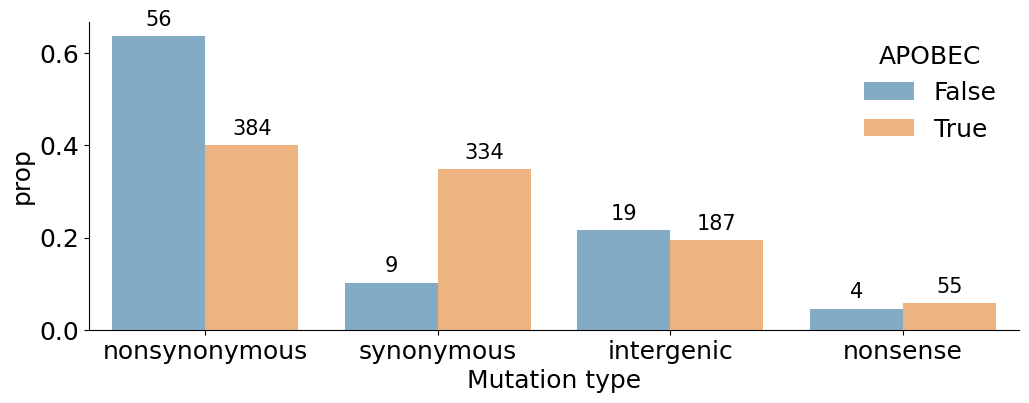

In [57]:

df = pd.read_csv("updated_2022-09-02/mut_counts.both.csv")
fig,ax= plt.subplots(figsize=(12,4),facecolor='w',frameon=False)

bar1 = sns.barplot(x=df["mutation_type"],  y=df["prop"], hue=df["APOBEC"], alpha=0.6,order=order)
bar_index = 0
for p in bar1.patches:
    
    bar1.annotate(labs[bar_index], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 12), 
                   textcoords = 'offset points')
    bar_index+=1
sns.move_legend(ax, "upper right", frameon=False,title="APOBEC")
[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.xlabel("Mutation type")
    
    
plt.savefig("figures/amino_acid_mutation_types.count.updated_2022-09-02.svg");
plt.savefig("figures/amino_acid_mutation_types.count.updated_2022-09-02.png",bbox_inches='tight', 
               transparent=True);

plt.show();

23718 960
[14618, 4990, 692, 3418, 384, 334, 55, 187]


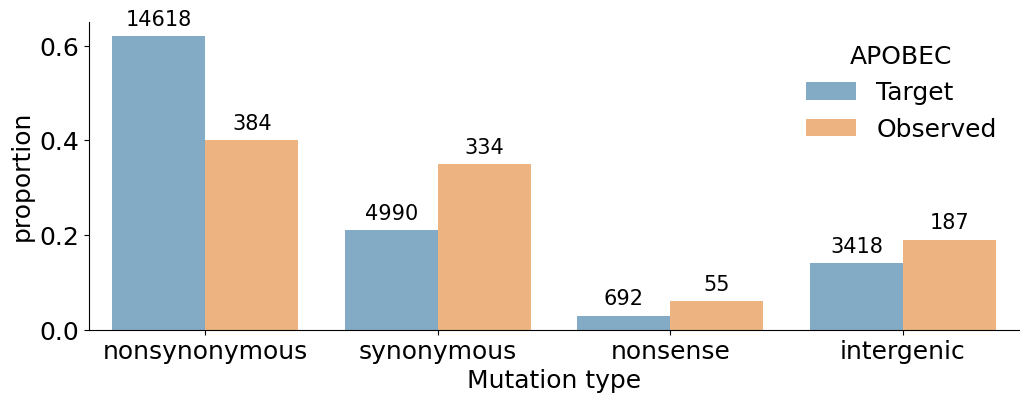

In [44]:
total_type = sum(type_counter.values())
total_apo = sum([len(apo_type_counter[i]) for i in apo_type_counter])
print(total_type, total_apo)
order = ["nonsynonymous","synonymous","nonsense","intergenic"]
with open("updated_2022-09-02/amino_acid_mutation_types.both_phylogenies.csv","w") as fw:
    fw.write("mutation_type,description,count,proportion\n")
    for i in order:
        prop_target = round(type_counter[i]/total_type,2)
        prop_observed = round(len(apo_type_counter[i])/total_apo,2)
        fw.write(f"{i},Target,{type_counter[i]},{prop_target}\n")
        fw.write(f"{i},Observed,{len(apo_type_counter[i])},{prop_observed}\n")
labs = []        
for i in order:
    labs.append(type_counter[i])
for i in order:
    labs.append(len(apo_type_counter[i]))  
print(labs)

df = pd.read_csv("updated_2022-09-02/amino_acid_mutation_types.both_phylogenies.csv")
fig,ax= plt.subplots(figsize=(12,4),facecolor='w',frameon=False)

bar1 = sns.barplot(x=df["mutation_type"],  y=df["proportion"], hue=df["description"], alpha=0.6)
bar_index = 0
for p in bar1.patches:
    
    bar1.annotate(labs[bar_index], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 12), 
                   textcoords = 'offset points')
    bar_index+=1
sns.move_legend(ax, "upper right", frameon=False,title="APOBEC")
[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.xlabel("Mutation type")
    
    
plt.savefig("figures/amino_acid_mutation_types.updated_2022-09-02.svg");
plt.savefig("figures/amino_acid_mutation_types.updated_2022-09-02.png",bbox_inches='tight', 
               transparent=True);

plt.show();

In [46]:
total_type = sum(type_counter.values())
total_nonapo = sum([len(non_apo_counter[i]) for i in non_apo_counter])
print(total_type, total_nonapo)
order = ["nonsynonymous","synonymous","nonsense","intergenic"]
with open("updated_2022-09-02/amino_acid_mutation_types.non_apo.both_phylogenies.csv","w") as fw:
    fw.write("mutation_type,description,count,proportion\n")
    for i in order:
        prop_target = round(len(total_nonapo[i])/total_nonapo,2)
        prop_observed = round(len(non_apo_counter[i])/total_nonapo,2)
        fw.write(f"{i},Target,{non_apo_counter[i]},{prop_target}\n")
        fw.write(f"{i},Observed,{len(non_apo_counter[i])},{prop_observed}\n")
labs = []        
for i in order:
    labs.append(non_apo_counter[i])
for i in order:
    labs.append(len(non_apo_counter[i]))  
print(labs)

df = pd.read_csv("updated_2022-09-02/amino_acid_mutation_types.non_apo.both_phylogenies.csv")
fig,ax= plt.subplots(figsize=(12,4),facecolor='w',frameon=False)

bar1 = sns.barplot(x=df["mutation_type"],  y=df["proportion"], hue=df["description"], alpha=0.6)
bar_index = 0
for p in bar1.patches:
    
    bar1.annotate(labs[bar_index], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 12), 
                   textcoords = 'offset points')
    bar_index+=1
sns.move_legend(ax, "upper right", frameon=False,title="Not APOBEC")
[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.xlabel("Mutation type")
    
    
plt.savefig("figures/amino_acid_mutation_types.non_apo.updated_2022-09-02.svg");
plt.savefig("figures/amino_acid_mutation_types.non_apo.updated_2022-09-02.png",bbox_inches='tight', 
               transparent=True);

plt.show();

23718 88


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [101]:
132/total_apo

0.20853080568720378

In [110]:


directory = "updated_2022-08-23"
alignment = "Clade_IIb_2022-08-22_with_gisaid.fasta"
tree = "Clade_IIb_2022-08-22_with_gisaid.pruned.tree"

def run_full_analysis(directory, alignment, tree):
    generate_reconstruction_files(directory, 
                                  alignment,
                                  tree)

    load_info(directory,alignment,tree,f"{tree}.fig")

    make_apobec_context_internal_plot(f"{directory}/{tree}.branch_snps.reconstruction.csv",
                                            f"{directory}/{tree}.branch_snps.counts.csv",
                                            f"{tree}.internal.counts")


    make_apobec_context_mutation_count_plot(f"{directory}/{tree}.branch_snps.reconstruction.csv",
                                            f"{directory}/{tree}.branch_snps.counts.csv",
                                            f"{tree}.all.counts")

    make_apobec_context_external_plot(f"{directory}/{tree}.branch_snps.reconstruction.csv",
                                            f"{directory}/{tree}.branch_snps.counts.csv",
                                            f"{tree}.external.counts")

    get_reconstruction_amino_acids(directory,alignment,tree)

    get_root_to_tip_counts(f"{directory}/{tree}.amino_acid.reconstruction.csv",
                           f"{directory}/{tree}.state_differences.csv",
                           f"{directory}/APOBEC_reconstructed_SNPs.csv",
                           f"{directory}/root_to_tip.data.csv")



59 snps


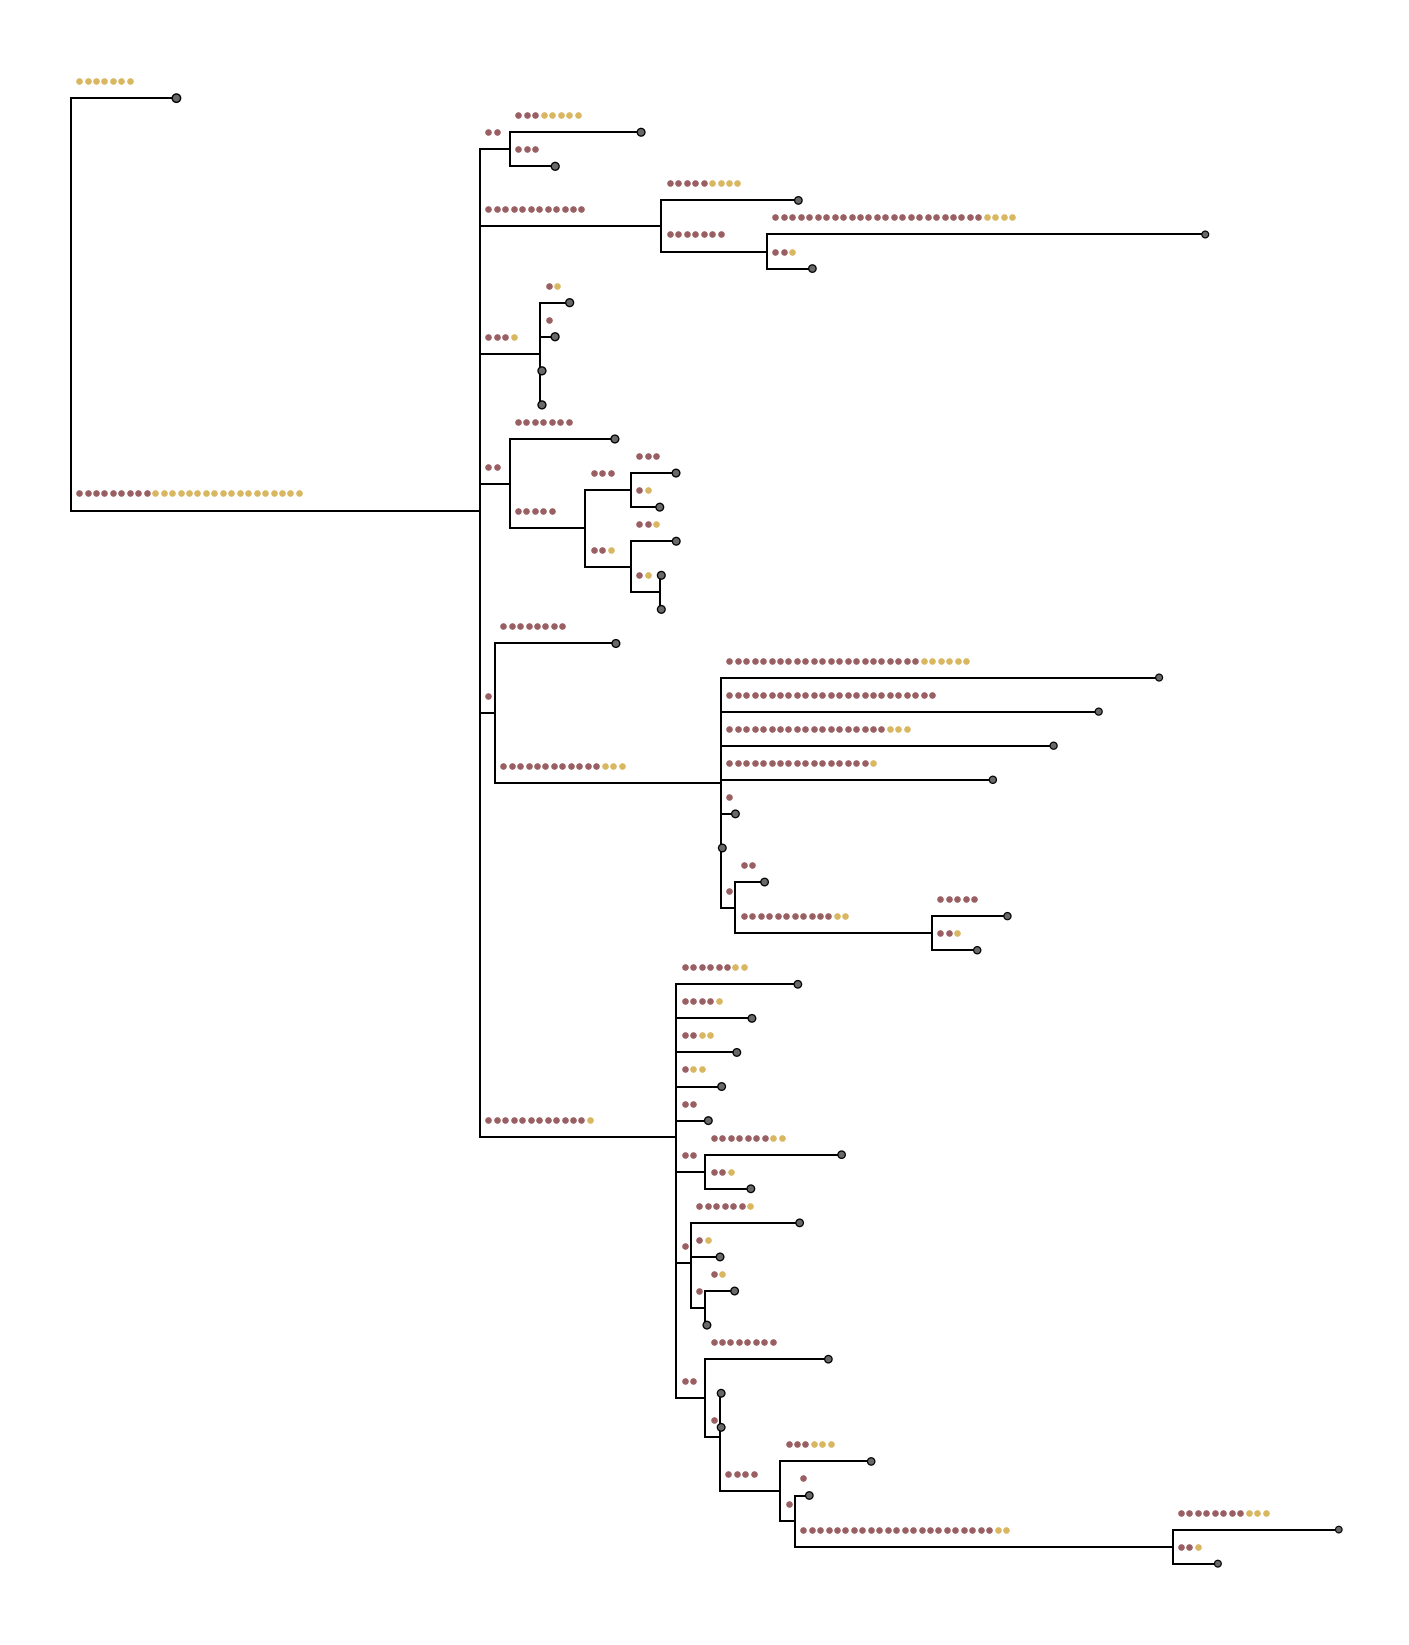

120 109 0.9083333333333333


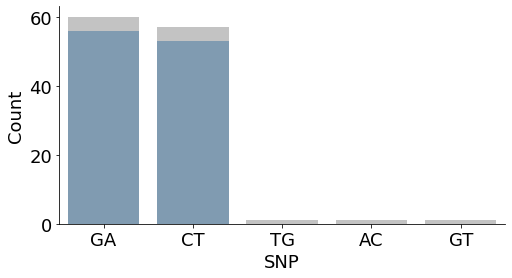

377 318 0.843501326259947


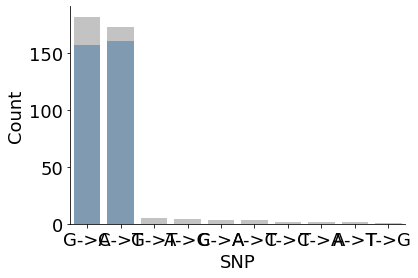

257 209 0.8132295719844358


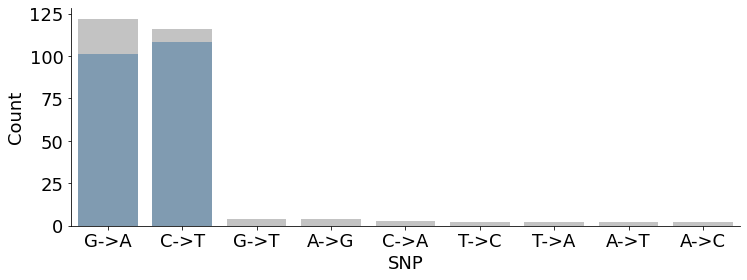

Node states 197209
12
{3450: 2, 23353: 2, 61844: 2, 187428: 2, 156429: 2, 127906: 2, 162243: 2, 29887: 2, 164832: 2, 168365: 2, 39139: 2, 2039: 2}
2019-07-11 2019.5232876712328 day
2019-04-20 2019.2986301369863 day
2019-10-07 2019.7643835616439 day
2019-04-20 2019.2986301369863 day
2022-05-19 2022.3780821917808 day
2021-11-16 2021.8739726027397 day
2019-06-26 2019.482191780822 day
2021-07-15 2021.5342465753424 day
2022-08-16 2022.6219178082192 month
2022-07-17 2022.5397260273974 day
2017-11-09 2017.854794520548 day
2017-11-09 2017.854794520548 day
2017-12-06 2017.9287671232876 day
2017-11-30 2017.9123287671232 day
2017-11-09 2017.854794520548 day
2017-11-16 2017.8739726027397 month
2017-10-09 2017.7698630136986 day
2018-10-04 2018.7561643835616 day
2018-09-07 2018.682191780822 day
2018-09-07 2018.682191780822 day
2018-09-22 2018.7232876712328 day
2018-08-16 2018.6219178082192 month
2022-05-22 2022.386301369863 day
2022-05-27 2022.4 day
2022-06-03 2022.4191780821918 day
2022-06-29 2022.

In [113]:

directory = "updated_2022-09-02/hMPXV1/"
tree = "Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree"
alignment="Clade_IIb_2022-08-22_with_gisaid.aln.fasta"
run_full_analysis(directory, alignment, tree)

120 109 0.9083333333333333


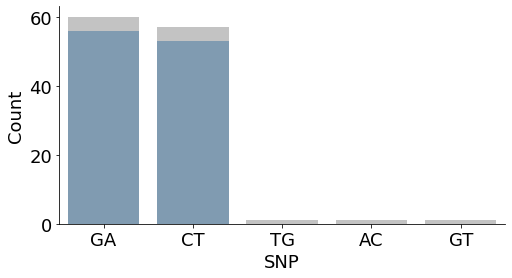

In [93]:

directory = "updated_2022-09-02/hMPXV1/"
tree = "Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree"
alignment="Clade_IIb_2022-08-22_with_gisaid.aln.fasta"
make_apobec_context_internal_plot(f"{directory}/{tree}.branch_snps.reconstruction.csv",
                                            f"{directory}/{tree}.branch_snps.counts.csv",
                                            f"{tree}.internal.counts")

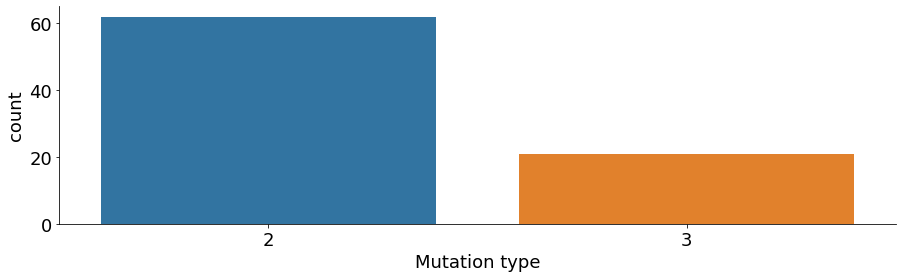

In [131]:
df = pd.read_csv("updated_2022-09-02/B.1/B.1_2022-08-22.og.aln.pruned.tree.amino_acid.reconstruction.csv")
h = df[df["homoplasy"]==True]
# h


fig,ax= plt.subplots(figsize=(15,4),facecolor='w',frameon=False)

sns.countplot(x=h["occurrence"])


[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.xlabel("Mutation type")
    
    
plt.savefig("figures/homoplasies.b.1.updated_2022-09-02.svg");
plt.savefig("figures/homoplasies.b.1.updated_2022-09-02.png",bbox_inches='tight', 
               transparent=True);

plt.show();




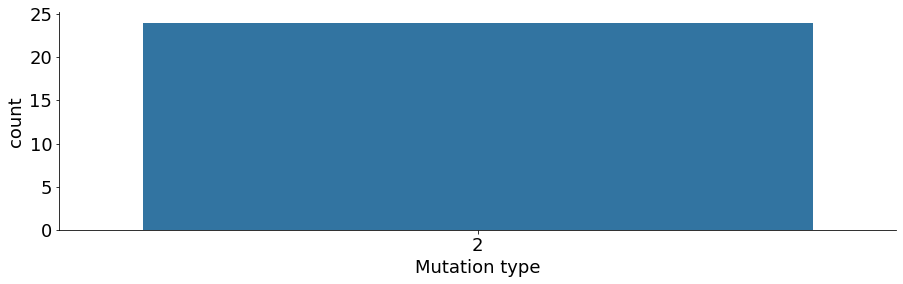

In [132]:
df = pd.read_csv("updated_2022-09-02/hMPXV1/Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree.amino_acid.reconstruction.csv")
h = df[df["homoplasy"]==True]
# h


fig,ax= plt.subplots(figsize=(15,4),facecolor='w',frameon=False)

sns.countplot(x=h["occurrence"])


[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.xlabel("Mutation type")
    
    
plt.savefig("figures/homoplasies.updated_2022-09-02.svg");
plt.savefig("figures/homoplasies.updated_2022-09-02.png",bbox_inches='tight', 
               transparent=True);

plt.show();




446 snps


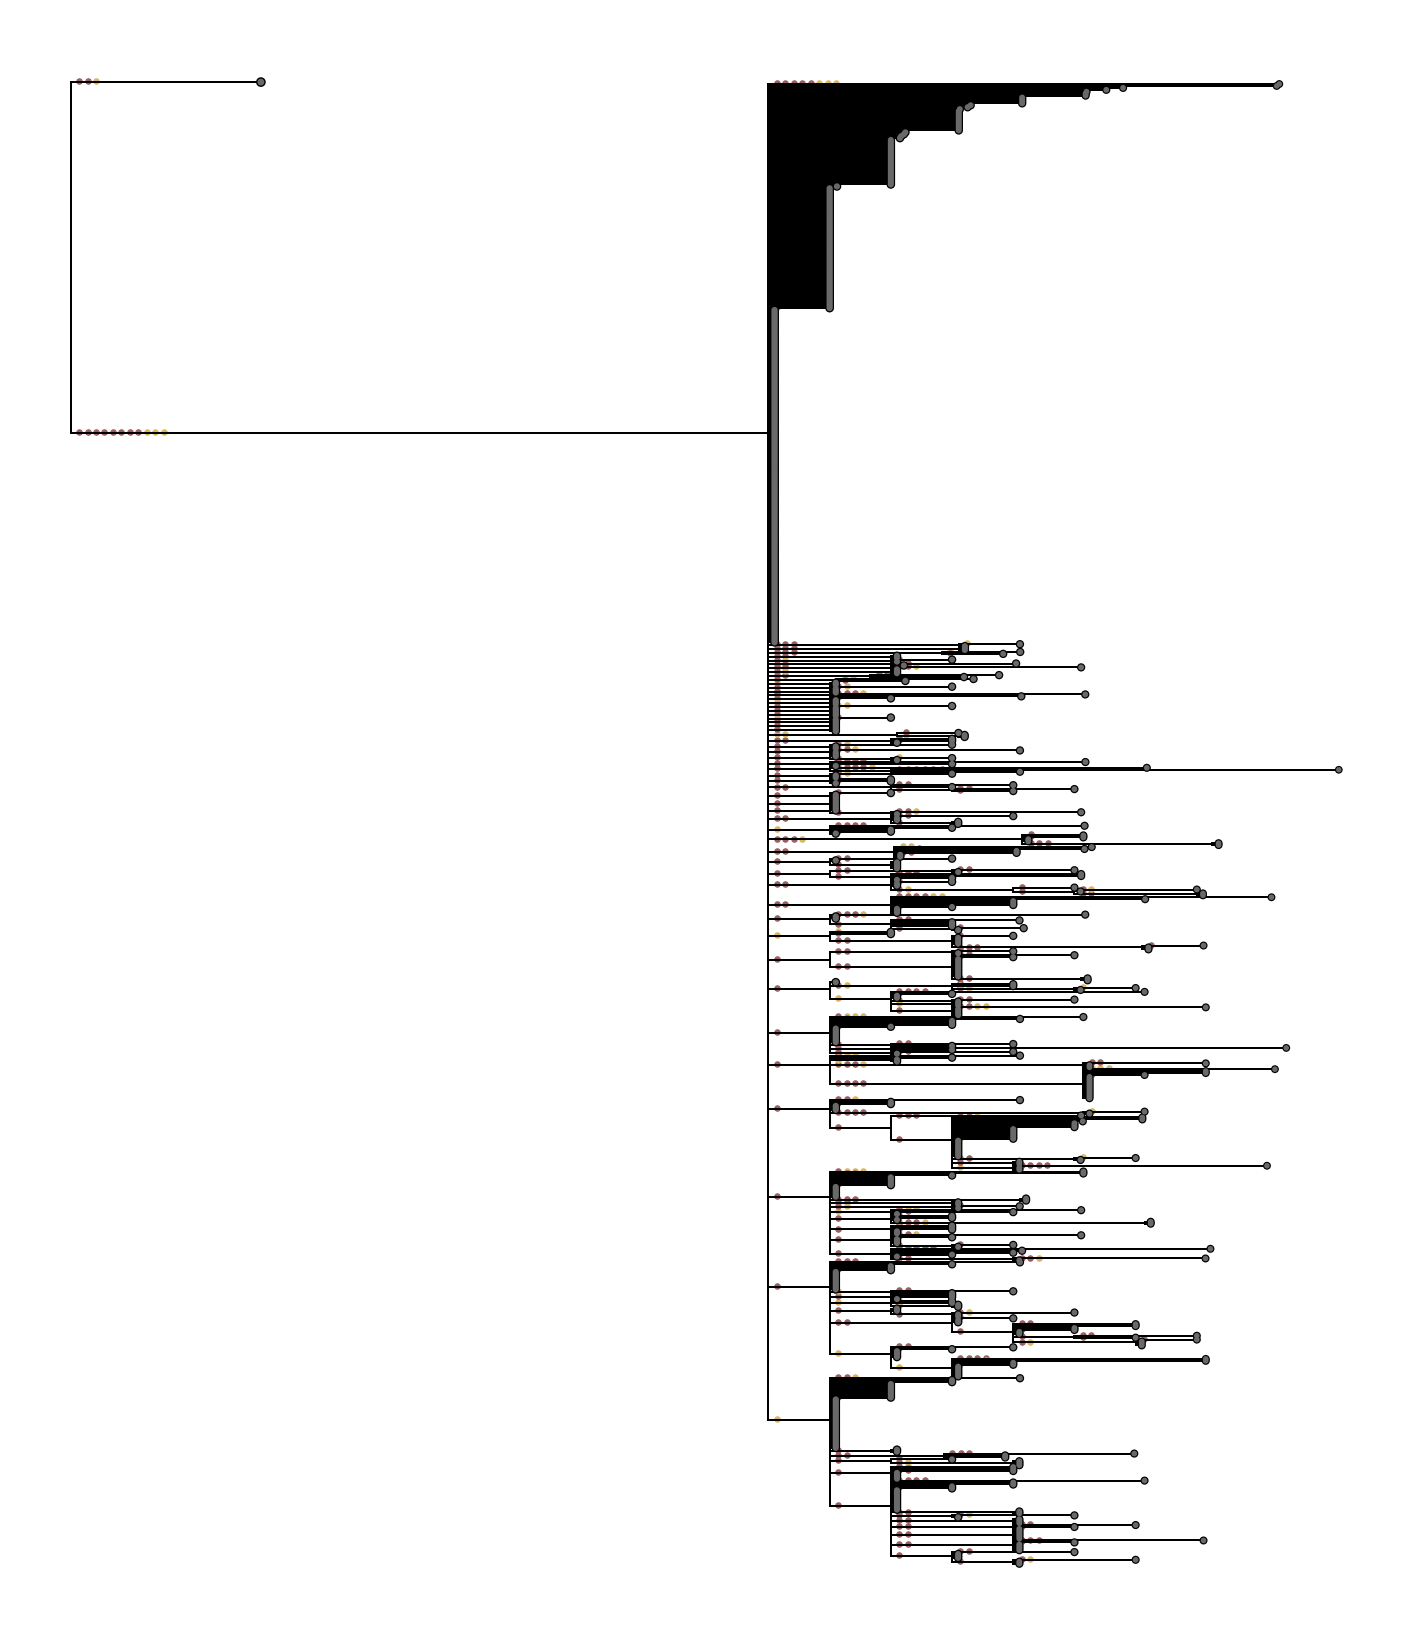

191 162 0.8481675392670157


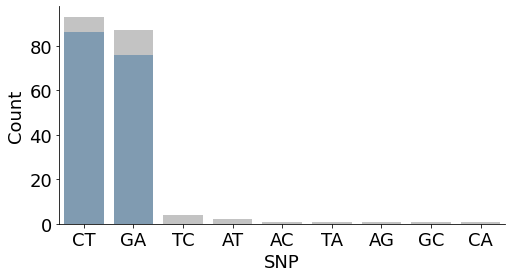

776 624 0.8041237113402062


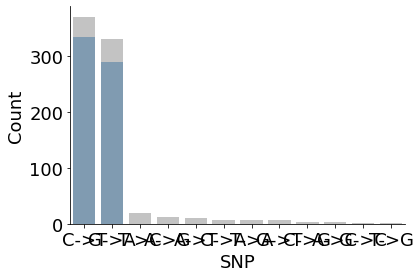

585 462 0.7897435897435897


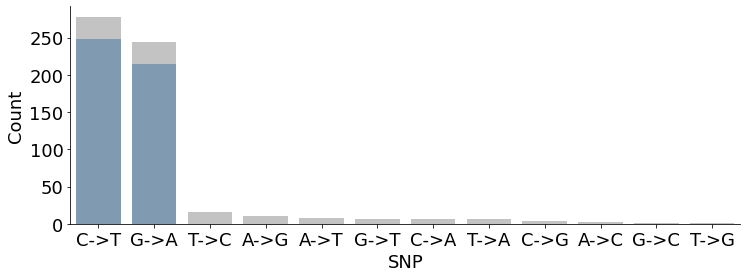

Node states 197209
37
{186165: 2, 55133: 3, 100182: 3, 20992: 2, 61253: 2, 44220: 2, 157527: 2, 150087: 2, 156429: 2, 6999: 2, 32627: 2, 103240: 2, 38937: 2, 63811: 3, 179853: 2, 181495: 2, 132520: 2, 70190: 3, 32715: 2, 77807: 2, 25644: 3, 63147: 3, 182189: 2, 98456: 2, 123397: 2, 70780: 2, 190668: 2, 33103: 2, 156469: 2, 94798: 2, 170698: 2, 49892: 2, 132625: 2, 102694: 2, 14611: 2, 52752: 2, 10484: 2}


/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/Bio/Seq.py:2738: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


2022-07-11 2022.5232876712328 day
2022-07-16 2022.5369863013698 month
2022-08-16 2022.6219178082192 month
2022-06-06 2022.427397260274 day
2022-06-16 2022.454794520548 month
2022-07-16 2022.5369863013698 month
2022-07-16 2022.5369863013698 month
2022-07-16 2022.5369863013698 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-05-16 2022.3698630136987 month
2022-07-13 2022.5287671232877 day
2022-05-18 2022.3753424657534 day
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-01 2022.5808219178082 day
2022-07-16 2022.5369863013698 month
2022-05-16 2022.3698630136987 month
2022-05-19 2022.3780821917808 day
2022-05-04 2022.33698630137 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-17 2022.372602739726 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.367123287

2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.621917808219

In [114]:

directory = "updated_2022-09-02/B.1/"
tree = "B.1_2022-08-22.og.aln.pruned.tree"
alignment="B.1_2022-08-22.og.aln.fasta"
run_full_analysis(directory, alignment, tree)

In [105]:
with open("updated_2022-09-02/hMPXV1_pub/Clade_IIb_2022-08-22_with_gisaid.aln.fasta","w") as fw:
    for record in SeqIO.parse("updated_2022-09-02/hMPXV1/Clade_IIb_2022-08-22_with_gisaid.aln.fasta","fasta"):
        if not "Thailand" in record.id and not "unpublished" in record.id:
            fw.write(f">{record.id}\n{record.seq}\n")
        else:
            print(record.id)
    

unpublished|9000312|UK|2022-08
unpublished|MPX/003/19|Nigeria_Bayelsa_State|2019-01-12
unpublished|MPX/007/19|Nigeria_Bayelsa_State|2019-01-30
unpublished|MPX/013/79|Nigeria_Bayelsa_State|2019-02-20
unpublished|MPX/015/19|Nigeria_Rivers_State|2019-03-12
unpublished|MPX/017/19|Nigeria_Rivers_State|2019-11-02
unpublished|MPX/018/19|Nigeria_Delta_State|2019-03-14
unpublished|MPX/021/19|Nigeria_Lagos_State|2019-04-01
unpublished|MPX/039/19|Nigeria_Bayelsa_State|2019-04-20
unpublished|MPX/040/19|Nigeria_Bayelsa_State|2019-04-20
unpublished|MPX/042/19|Nigeria_Delta_State|2019-04-18
unpublished|MPX/046/19|Nigeria_Lagos_State|2019-05-10
unpublished|MPX/052/19|Nigeria_Delta_State|2019-05-29
unpublished|MPX/053/19|Nigeria_Delta_State|2019-06-26
unpublished|MPX/058/19|Nigeria_Enugu_State|2019-07-11
unpublished|MPX/104/19|Nigeria_Oyo_State|2019-10-07
unpublished|MPX/111/19|Nigeria_Rivers_State|2019-12-17
unpublished|MPX/113/19|Nigeria_Imo_State|2019-12-17
unpublished|MPX/191/20|Nigeria|2020-01-23


27 snps


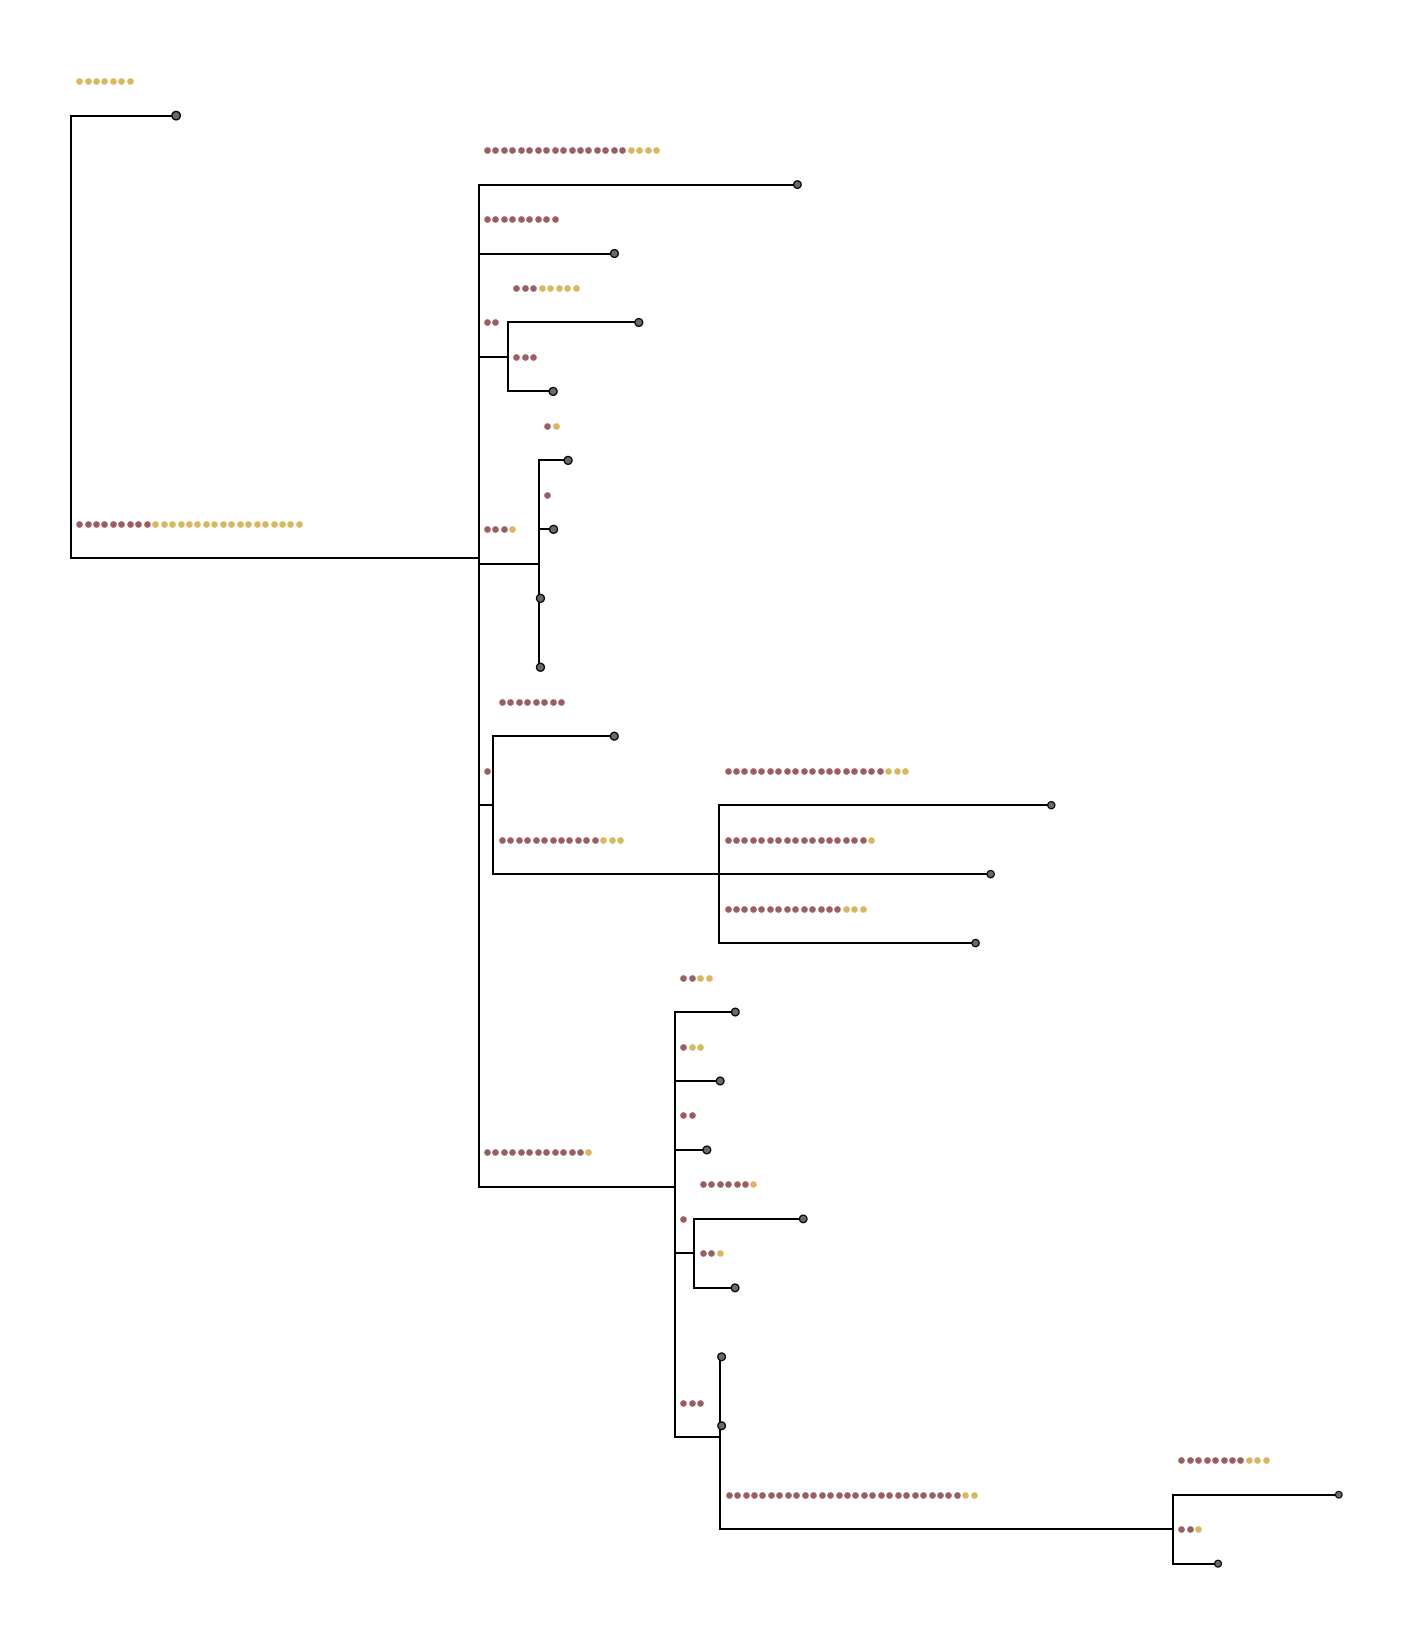

69 62 0.8985507246376812


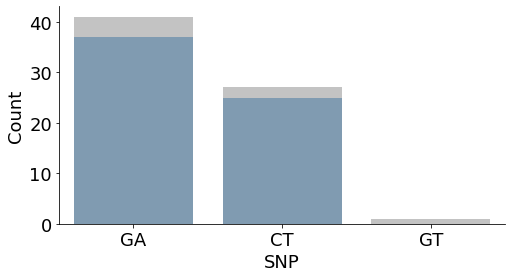

211 177 0.8388625592417062


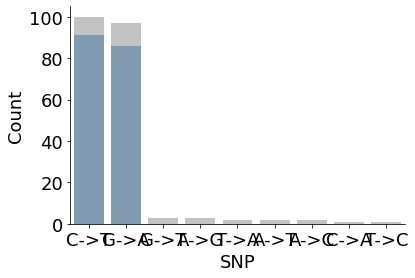

142 115 0.8098591549295775


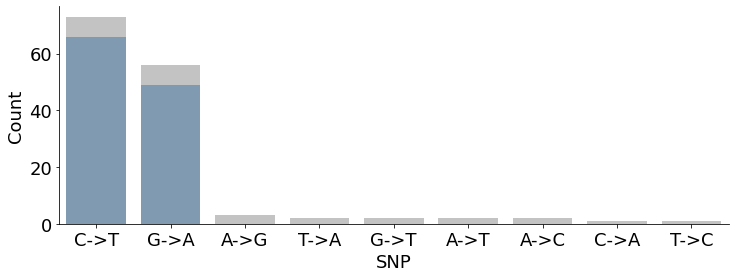

Node states 197209
Duplicate mutation 156429
Duplicate mutation 61844
Duplicate mutation 164832
Duplicate mutation 3450
Duplicate mutation 29887
Duplicate mutation 39139
6
Counter({'156429': 1, '61844': 1, '164832': 1, '3450': 1, '29887': 1, '39139': 1})
2022-05-19 2022.3780821917808 day
2021-11-16 2021.8739726027397 day
2021-07-15 2021.5342465753424 day
2017-11-09 2017.854794520548 day
2017-11-09 2017.854794520548 day
2017-12-06 2017.9287671232876 day
2017-11-30 2017.9123287671232 day
2017-11-09 2017.854794520548 day
2017-11-16 2017.8739726027397 month
2017-10-09 2017.7698630136986 day
2018-10-04 2018.7561643835616 day
2018-09-07 2018.682191780822 day
2018-09-07 2018.682191780822 day
2018-09-22 2018.7232876712328 day
2018-08-16 2018.6219178082192 month
2022-05-22 2022.386301369863 day
2022-05-27 2022.4 day
2017 2017.5 year
2019-05-08 2019.3479452054794 day
2019-12-03 2019.9205479452055 day
2018-08-14 2018.6164383561643 day
1971-04-14 1971.282191780822 day
1978 1978.5 year


In [106]:

directory = "updated_2022-09-02/hMPXV1_pub/"
tree = "Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree"
alignment="Clade_IIb_2022-08-22_with_gisaid.aln.fasta"
run_full_analysis(directory, alignment, tree)

59 snps


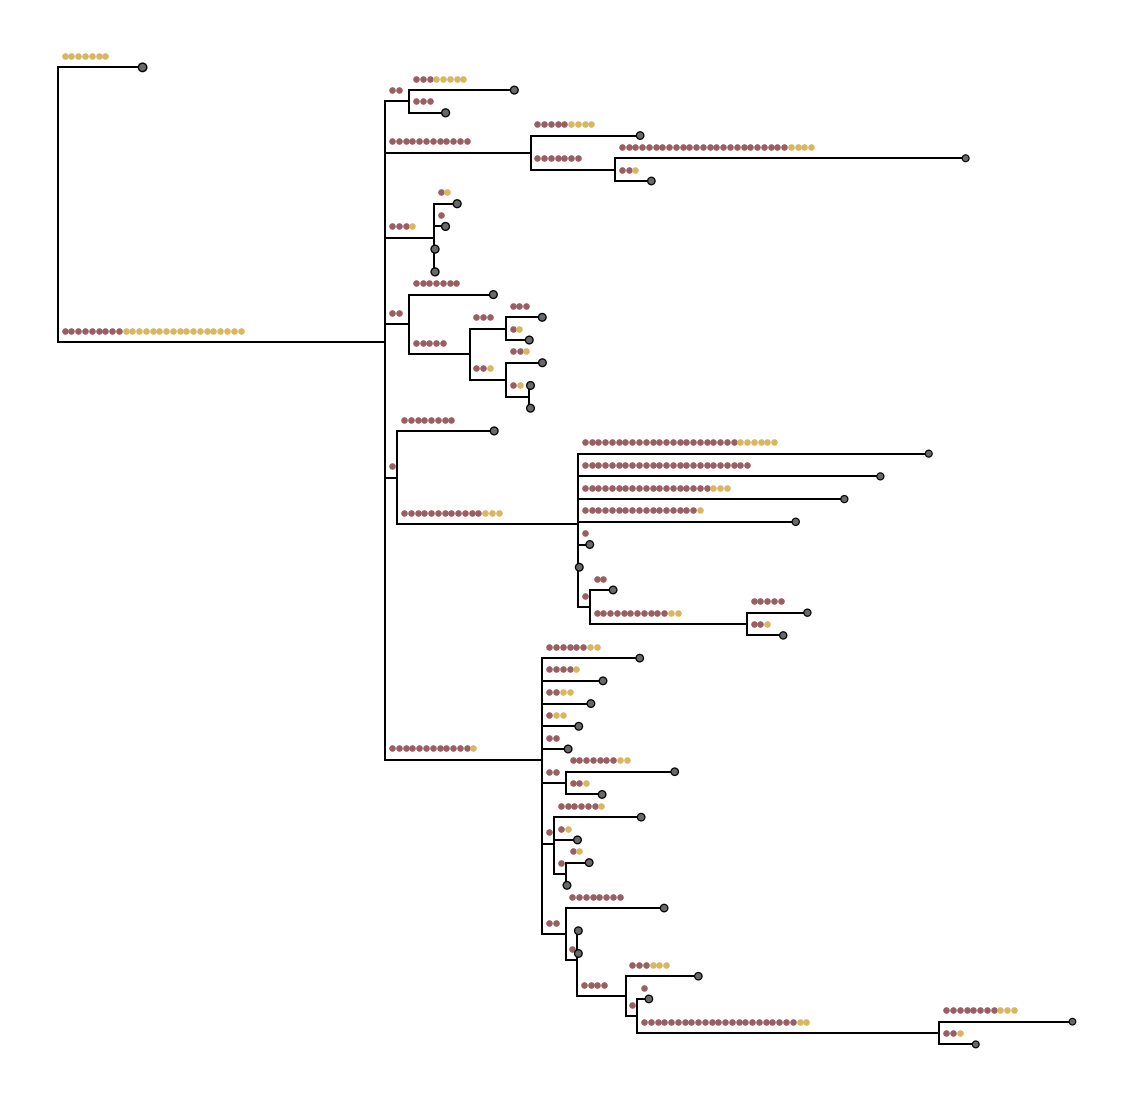

In [97]:


directory = "updated_2022-09-02/hMPXV1/"
alignment = "Clade_IIb_2022-08-22_with_gisaid.aln.fasta"
tree = "Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree"
load_info(directory,alignment,tree,f"{tree}.fig",20,20)

450 snps


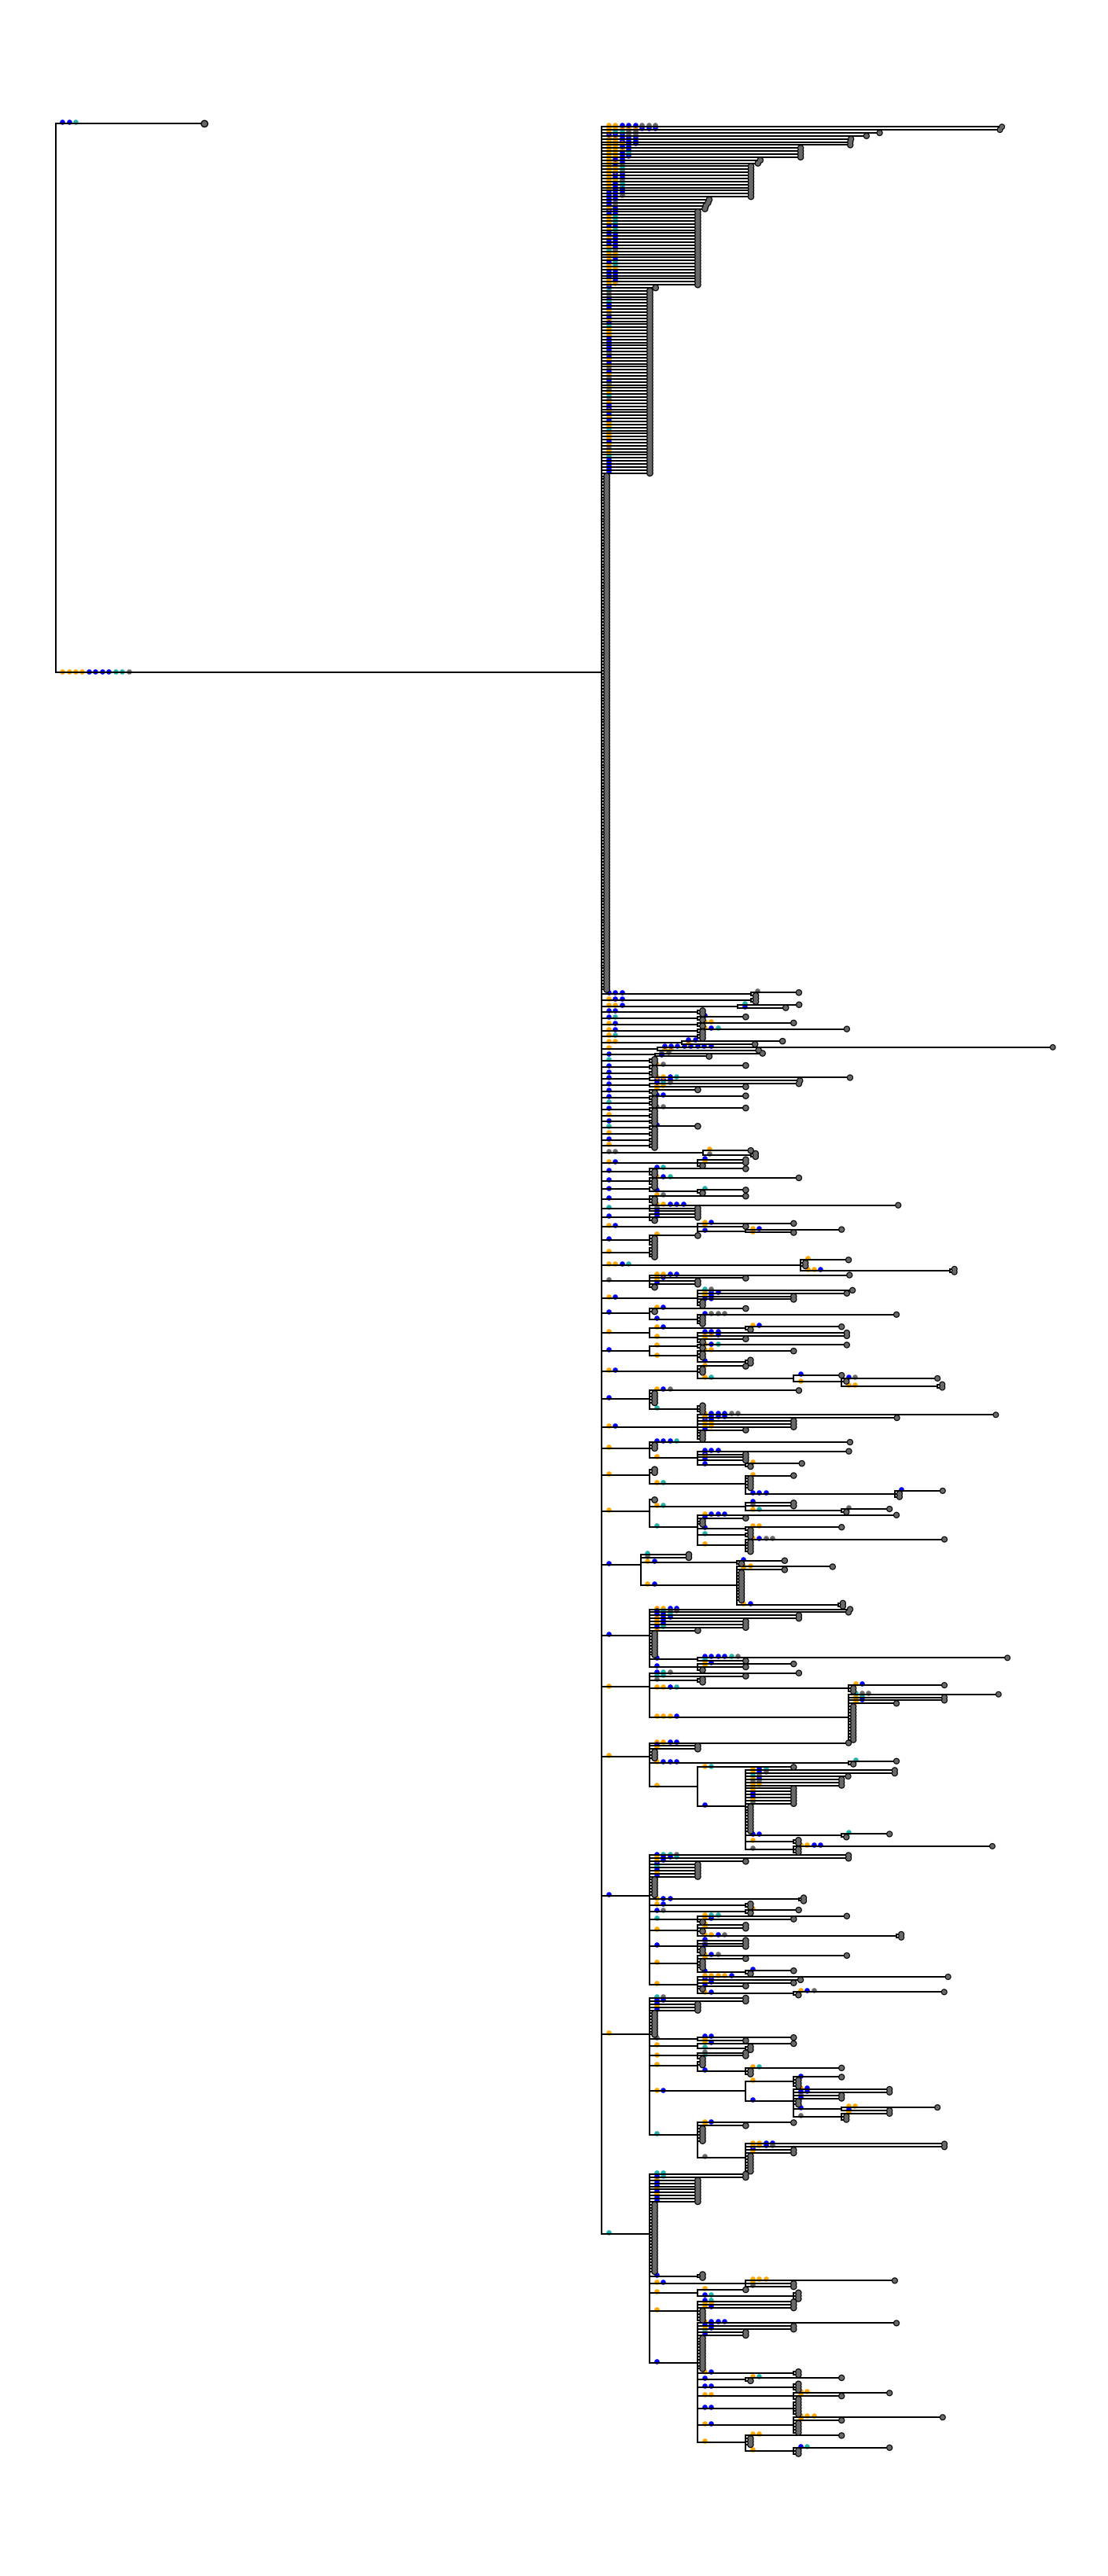

In [69]:

directory = "updated_2022-09-02/B.1/"
tree = "B.1_2022-08-22.og.aln.pruned.tree"
alignment="B.1_2022-08-22.og.aln.fasta"
load_info(directory,alignment,tree,f"{tree}.fig",25,40)

In [79]:

directory = "updated_2022-09-02/B.1/"
tree = "B.1_2022-08-22.og.aln.pruned.tree"
alignment="B.1_2022-08-22.og.aln.fasta"
get_root_to_tip_counts(f"{directory}/{tree}.amino_acid.reconstruction.csv",
                           f"{directory}/{tree}.state_differences.csv",
                           f"{directory}/APOBEC_reconstructed_SNPs.csv",
                           f"{directory}/root_to_tip.data.csv")

2022-07-11 2022.5232876712328 day
2022-07-16 2022.5369863013698 month
2022-08-16 2022.6219178082192 month
2022-06-06 2022.427397260274 day
2022-06-16 2022.454794520548 month
2022-07-16 2022.5369863013698 month
2022-07-16 2022.5369863013698 month
2022-07-16 2022.5369863013698 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-05-16 2022.3698630136987 month
2022-07-13 2022.5287671232877 day
2022-05-18 2022.3753424657534 day
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-01 2022.5808219178082 day
2022-07-16 2022.5369863013698 month
2022-05-16 2022.3698630136987 month
2022-05-19 2022.3780821917808 day
2022-05-04 2022.33698630137 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-17 2022.372602739726 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.367123287

2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-06-16 2022.454794520548 month
2022-06-16 2022.454794520548 month
2022-06-16 2022.454794520548 month
2022-06-16 2022.454794520548 month
2022-06-16 2022.454794520548 month
2022-06-16 2022.454794520548 month
2022-06-16 2022.454794520548 month
2022-06-16 2022.454794520548 month
2022-06-16 2022.454794520548 month
2022-06-16 2022.454794520548 month
2022-07-11 2022.5232876712328 day
2022-08-01 2022.5808219178082 day
2022-08-01 2022.5808219178082 day
2022-07-31 2022.5780821917808 day
2022-07-30 2022.5753424657535 day
2022-08-01 2022.5808219178082 day
2022-07-28 2022.5698630136985 day
2022-07-29 2022.572602739726 day
2022-07-28 2022.5698630136985 day
2022-07-28 2022.5698630136985 day
2022-08-01 2022.5808219

450 snps


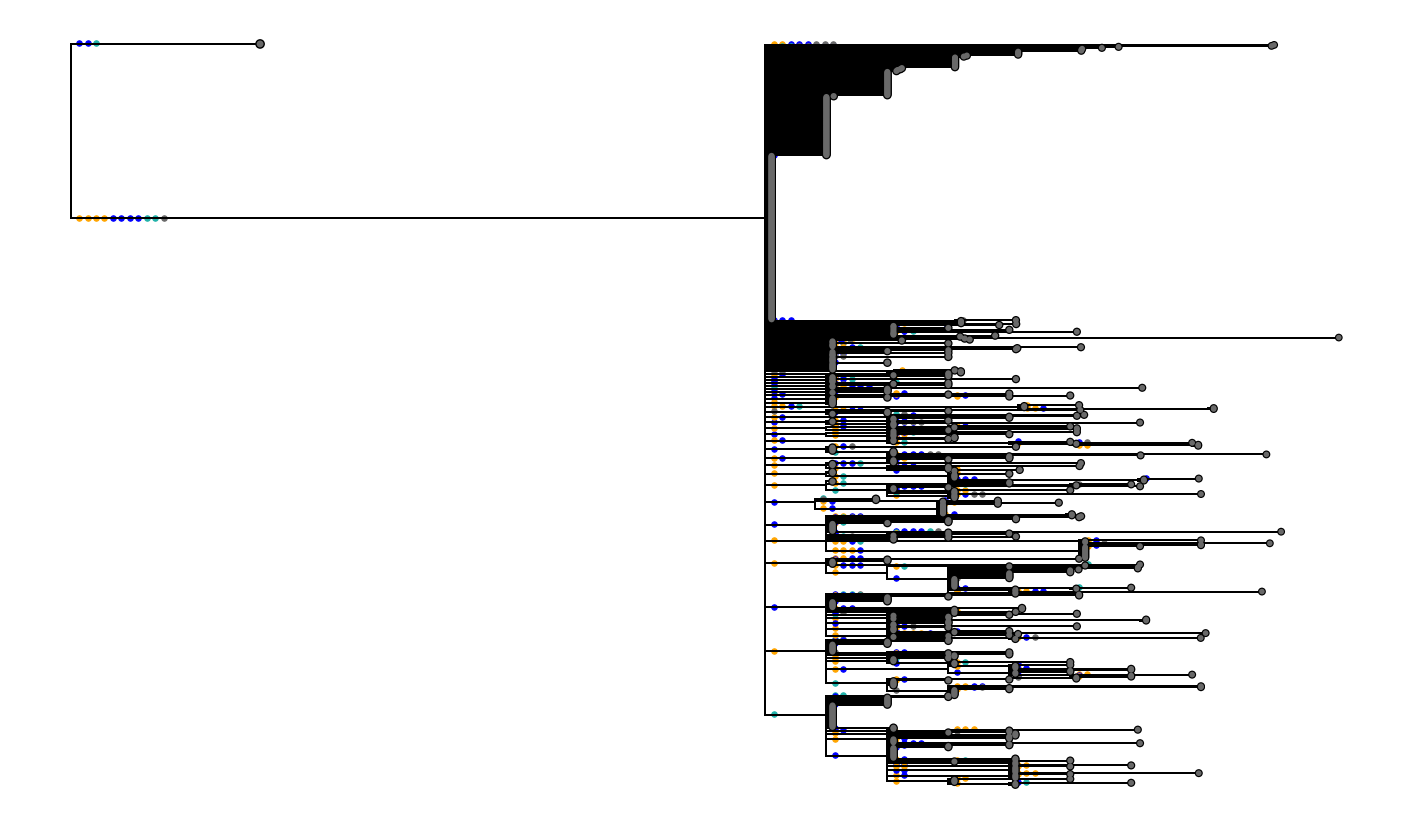

192 161 0.8385416666666666


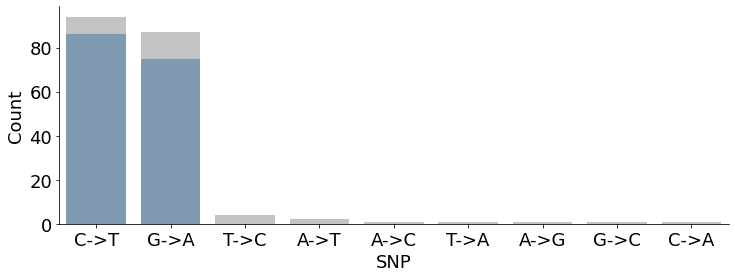

786 627 0.7977099236641222


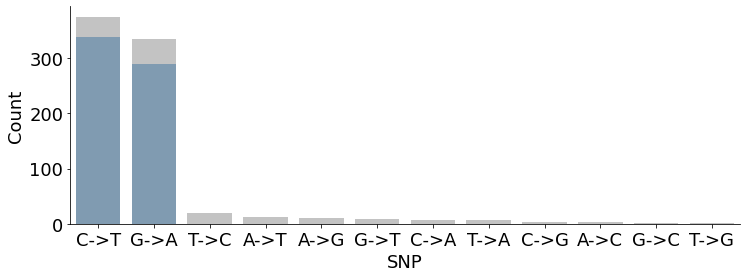

594 466 0.7845117845117845


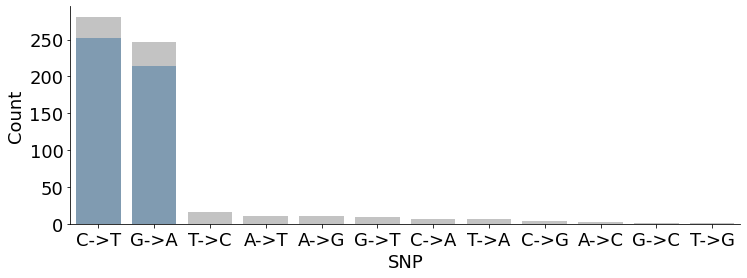

Node states 197209
Duplicate mutation 147168
Duplicate mutation 61253
Duplicate mutation 5375
Duplicate mutation 157527
Duplicate mutation 5375
Duplicate mutation 44220
Duplicate mutation 55133
Duplicate mutation 100182
Duplicate mutation 64426
Duplicate mutation 150087
Duplicate mutation 70190
Duplicate mutation 77807
Duplicate mutation 63811
Duplicate mutation 63147
Duplicate mutation 25644
Duplicate mutation 63147
Duplicate mutation 190668
Duplicate mutation 6999
Duplicate mutation 33103
Duplicate mutation 123397
Duplicate mutation 156469
Duplicate mutation 94798
Duplicate mutation 38937
Duplicate mutation 32627
Duplicate mutation 133103
Duplicate mutation 156429
Duplicate mutation 103240
Duplicate mutation 182189
Duplicate mutation 74360
Duplicate mutation 181495
Duplicate mutation 143074
Duplicate mutation 63811
Duplicate mutation 132625
Duplicate mutation 98456
Duplicate mutation 102694
Duplicate mutation 133867
Duplicate mutation 70190
Duplicate mutation 32715
Duplicate mutation

/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/Bio/Seq.py:2738: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


2022-07-11 2022.5232876712328 day
2022-07-16 2022.5369863013698 month
2022-08-16 2022.6219178082192 month
2022-06-06 2022.427397260274 day
2022-06-16 2022.454794520548 month
2022-07-16 2022.5369863013698 month
2022-07-16 2022.5369863013698 month
2022-07-16 2022.5369863013698 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-05-16 2022.3698630136987 month
2022-07-13 2022.5287671232877 day
2022-05-18 2022.3753424657534 day
2022-08-16 2022.6219178082192 month
2022-08-16 2022.6219178082192 month
2022-08-01 2022.5808219178082 day
2022-07-16 2022.5369863013698 month
2022-05-16 2022.3698630136987 month
2022-05-19 2022.3780821917808 day
2022-05-04 2022.33698630137 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-17 2022.372602739726 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.3671232876711 day
2022-05-15 2022.367123287

2022-07-11 2022.5232876712328 day
2022-08-01 2022.5808219178082 day
2022-08-01 2022.5808219178082 day
2022-07-31 2022.5780821917808 day
2022-07-30 2022.5753424657535 day
2022-08-01 2022.5808219178082 day
2022-07-28 2022.5698630136985 day
2022-07-29 2022.572602739726 day
2022-07-28 2022.5698630136985 day
2022-07-28 2022.5698630136985 day
2022-08-01 2022.5808219178082 day
2022-07-31 2022.5780821917808 day
2022-08-01 2022.5808219178082 day
2022-07-27 2022.5671232876712 day
2022-07-27 2022.5671232876712 day
2022-07-26 2022.5643835616438 day
2022-07-25 2022.5616438356165 day
2022-07-27 2022.5671232876712 day
2022-07-26 2022.5643835616438 day
2022-07-26 2022.5643835616438 day
2022-07-27 2022.5671232876712 day
2022-07-27 2022.5671232876712 day
2022-07-27 2022.5671232876712 day
2022-07-22 2022.5534246575342 day
2022-07-23 2022.5561643835617 day
2022-07-28 2022.5698630136985 day
2022-07-26 2022.5643835616438 day
2022-07-26 2022.5643835616438 day
2022-07-23 2022.5561643835617 day
2022-07-22 2022

ValueError: could not convert string to float: 'ON676708'

In [62]:
run_full_analysis("updated_2022-08-24_B.1/new_mask", "B.1_2022-08-22.og.aln.fasta", "B.1_2022-08-22.og.aln.fasta.pruned.tree")



In [65]:

directory = "updated_2022-08-23/"
tree = "Clade_IIb_2022-08-22_with_gisaid.pruned.tree"
alignment="Clade_IIb_2022-08-22_with_gisaid.fasta"
get_root_to_tip_counts(f"{directory}/{tree}.amino_acid.reconstruction.csv",
                           f"{directory}/{tree}.state_differences.csv",
                           f"{directory}/APOBEC_reconstructed_SNPs.csv",
                           f"{directory}/root_to_tip.data.csv")

2017 2017.5 year
2019-07-11 2019.5232876712328 day
2019-04-20 2019.2986301369863 day
2019-10-07 2019.7643835616439 day
2019-04-20 2019.2986301369863 day
2022-05-19 2022.3780821917808 day
2021-11-16 2021.8739726027397 day
2019-06-26 2019.482191780822 day
2021-07-15 2021.5342465753424 day
2022-07-17 2022.5397260273974 day
2017-11-09 2017.854794520548 day
2017-11-09 2017.854794520548 day
2017-12-06 2017.9287671232876 day
2017-11-30 2017.9123287671232 day
2017-11-09 2017.854794520548 day
2017-11-16 2017.8739726027397 month
2017-10-09 2017.7698630136986 day
2018-10-04 2018.7561643835616 day
2018-09-07 2018.682191780822 day
2018-09-07 2018.682191780822 day
2018-09-22 2018.7232876712328 day
2018-08-16 2018.6219178082192 month
2022-05-22 2022.386301369863 day
2022-05-27 2022.4 day
2022-06-03 2022.4191780821918 day
2022-06-29 2022.490410958904 day
2019-01-12 2019.0301369863014 day
2019-01-30 2019.0794520547945 day
2019-02-20 2019.13698630137 day
2019-03-12 2019.1917808219177 day
2019-11-02 2019

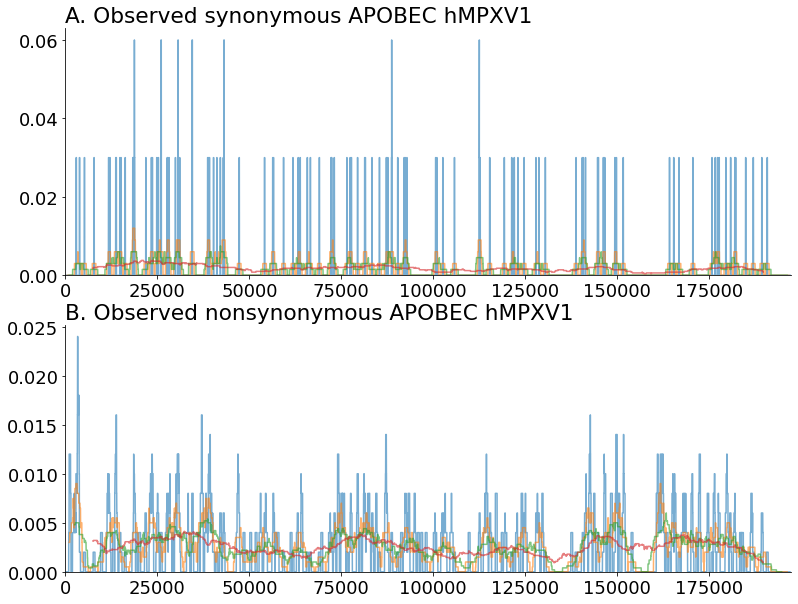

In [106]:
ref = str(SeqIO.read('/Users/s1680070/repositories/alignHPXV/squirrel/data/NC_063383.fasta', 'fasta').seq)
pos = np.arange(len(ref)-1)
synsites = []
nonsynsites = []
with open("updated_2022-09-02/hMPXV1/Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        
        if row["mutation_category"] == "synonymous":
            synsites.append(int(row["site"]))
        elif row["mutation_category"]== "nonsynonymous":
            nonsynsites.append(int(row["site"]))

y1 = []
for site in synsites:
    y1.append(1)
    
y2 = []
for site in nonsynsites:
    y2.append(1)



pos = np.arange(len(ref)-1)

fig, (ax0,ax1) = plt.subplots(2,figsize=(12,6),facecolor='w',frameon=False)


apobec_synonymous = []
for i in pos:
    if i+1 in synsites or i+2 in synsites or i in synsites:
        apobec_synonymous.append(True)
    else:
        apobec_synonymous.append(False)
apobec_synonymous = np.array(apobec_synonymous)


apobec_nonsynonymous = []
for i in pos:
    if i+1 in synsites or i+2 in nonsynsites or i in nonsynsites:
        apobec_nonsynonymous.append(True)
    else:
        apobec_nonsynonymous.append(False)
apobec_nonsynonymous = np.array(apobec_nonsynonymous)



for ws in [100, 1000, 2000, 15000]:
    w = np.ones(ws)/ws
    ax0.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_synonymous, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax0.spines[loc].set_visible(False) for loc in ['top','right']]
# ax0.legend(loc='best', bbox_to_anchor=(0.6, 0.1, 0.6, 1),frameon=False)

ax0.set_ylim(0)
ax0.set_xlim(0,197209)
ax0.set_title("A. Observed synonymous APOBEC hMPXV1",loc="left")


for ws in [500, 2000, 5000, 15000]:
    w = np.ones(ws)/ws
    ax1.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_nonsynonymous, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax1.spines[loc].set_visible(False) for loc in ['top','right']]

ax1.set_ylim(0)
ax1.set_xlim(0,197209)
ax1.set_title("B. Observed nonsynonymous APOBEC hMPXV1",loc="left")

plt.savefig("figures/apobec_syn_nonsyn.2022-08-23.convolve.svg");
plt.savefig("figures/apobec_syn_nonsyn.2022-08-23.convolve.png",bbox_inches='tight', 
               transparent=True);



In [12]:

target = []
for i in pos:
    if ref[i:i+2]=="GA" or ref[i:i+2]=="TC":
        target.append(i)
print(len(target))
observed = [int(i) for i in observed]



24695


In [33]:
for i in type_site_dict:
    print(i, len(type_site_dict[i]))

intergenic 3418
synonymous 4990
nonsynonymous 14618
nonsense 692


In [23]:
observed_synonymous = []
observed_nonsynonymous = []

with open("updated_2022-09-02/hMPXV1/Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["apobec"] == "True":
            if row["mutation_category"] == "nonsynonymous":
                observed_nonsynonymous.append(int(row["site"]))
            elif row["mutation_category"] in ["synonymous","intergenic"]:
                observed_synonymous.append(int(row["site"]))
        

with open("updated_2022-09-02/B.1/B.1_2022-08-22.og.aln.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if not row["parent"]=="Node1":
            if row["apobec"] == "True" and row["mutation_category"] == "nonsynonymous":
                observed_nonsynonymous.append(int(row["site"]))
            elif row["apobec"] == "True" and row["mutation_category"] in ["synonymous","intergenic"]:
                observed_synonymous.append(int(row["site"]))
        
                
# fig, (ax0,ax1) = plt.subplots(2,figsize=(12,6),facecolor='w',frameon=False)


# apobec_synonymous = np.array([i in observed_synonymous for i in pos])
# apobec_nonsynonymous = np.array([i in observed_nonsynonymous for i in pos])



In [40]:
observed_nonAPO_synonymous = []
observed_nonAPO_nonsynonymous = []

with open("updated_2022-09-02/hMPXV1/Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["apobec"] == "False":
            if row["mutation_category"] == "nonsynonymous":
                observed_nonAPO_nonsynonymous.append(int(row["site"]))
            elif row["mutation_category"] in ["synonymous","intergenic"]:
                observed_nonAPO_synonymous.append(int(row["site"]))
        

with open("updated_2022-09-02/B.1/B.1_2022-08-22.og.aln.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if not row["parent"]=="Node1":
            if row["apobec"] == "False" and row["mutation_category"] == "nonsynonymous":
                observed_nonAPO_nonsynonymous.append(int(row["site"]))
            elif row["apobec"] == "False" and row["mutation_category"] in ["synonymous","intergenic"]:
                observed_nonAPO_synonymous.append(int(row["site"]))
print(observed_nonAPO_nonsynonymous) 
print(observed_nonAPO_synonymous)
                

[3450, 38067, 46895, 48527, 53207, 80986, 92516, 105126, 137627, 142450, 146687, 149878, 160867, 167656, 122627, 151519, 176289, 176366, 74032, 102267, 161701, 114537, 124853, 9782, 20153, 87027, 165688, 104748, 114659, 161152, 95936, 13648, 64216, 179628, 93312, 162640, 174721, 91363, 147593, 61329, 14000, 95034, 170262, 86979, 75967, 1231, 150406, 2152, 184037, 13625, 119718, 129762, 149744, 160852, 5375, 89252, 168380, 67611, 74134, 21060, 40937, 138237, 44529, 97413, 164653, 44856, 54004, 36620, 50337, 48296, 109627, 88644, 112638, 143625, 168120, 18629, 161784, 14077, 37691, 147799, 174924, 123397, 123397, 161296, 34298, 119985, 139150, 89296, 2898, 93512, 46956, 28702, 161488, 28706, 87268, 56205, 150003, 77971, 63026, 162919, 127526, 51093, 13059, 13081, 49892, 49892, 41351, 12238, 151793, 144301, 12827, 12833, 30128, 56110, 170577, 23567, 33274, 117044, 98455, 61974, 159165, 162156, 61274, 83018, 69127, 83568, 32469, 107070, 139397, 153679, 171207, 91746, 48785, 45851, 2242, 23

In [20]:
from scipy.stats import ks_2samp

#perform Kolmogorov-Smirnov test
ks_2samp(target,observed)

KstestResult(statistic=0.06192886549233986, pvalue=0.0015964878726064963)

In [24]:
ks_2samp(target,observed_synonymous)

KstestResult(statistic=0.09640943891678089, pvalue=0.00014089389451274793)

In [ ]:
target_syn = np.array([i in type_site_dict["synonymous"] for i in pos])

In [35]:
ks_2samp(type_site_dict["synonymous"],observed_synonymous)

KstestResult(statistic=0.20082198946838015, pvalue=3.8169603361872056e-17)

In [ ]:
target_nonsyn = np.array([i in type_site_dict["nonsynonymous"] for i in pos])

In [36]:
ks_2samp(type_site_dict["nonsynonymous"],observed_nonsynonymous)

KstestResult(statistic=0.08830116694030188, pvalue=0.005490465691364161)

24695


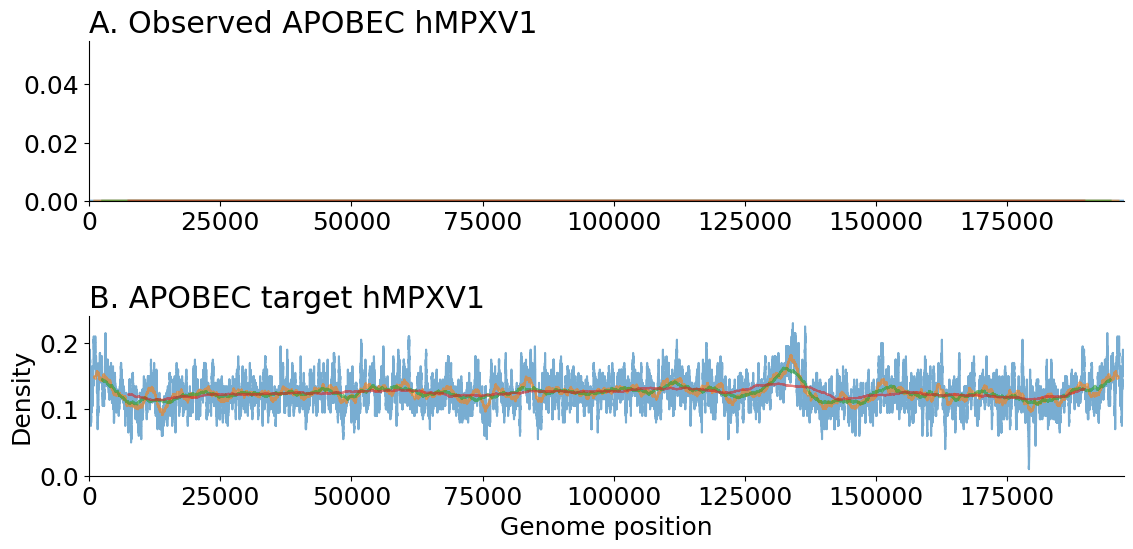

In [11]:

ref = str(SeqIO.read('/Users/s1680070/repositories/alignHPXV/squirrel/data/NC_063383.fasta', 'fasta').seq)

pos = np.arange(len(ref)-1)
apobec_observed = np.array([i in observed for i in pos])

fig, (ax0,ax1) = plt.subplots(2,figsize=(12,6),facecolor='w',frameon=False)

for ws in [200, 2000, 5000, 15000]:
    w = np.ones(ws)/ws
    
    ax0.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_observed, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax0.spines[loc].set_visible(False) for loc in ['top','right']]
# ax0.legend(loc='best', bbox_to_anchor=(0.6, 0.1, 0.6, 1),frameon=False)

ax0.set_ylim(0)
ax0.set_xlim(0,197209)
ax0.set_title("A. Observed APOBEC hMPXV1",loc="left")

apobec_target = np.array([ref[i:i+2]=='GA' or ref[i:i+2]=='TC' for i in pos])

target = []
for i in pos:
    if ref[i:i+2]=="GA" or ref[i:i+2]=="TC":
        target.append(i)
print(len(target))

for ws in [200, 2000, 5000, 15000]:
    w = np.ones(ws)/ws
    ax1.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_target, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax1.spines[loc].set_visible(False) for loc in ['top','right']]
# ax1.legend(loc='best', bbox_to_anchor=(0.6, 0.1, 0.6, 1),frameon=False)

ax1.set_ylim(0)
ax1.set_xlim(0,197209)
ax1.set_title("B. APOBEC target hMPXV1",loc="left")

fig.tight_layout(pad=2.0)

plt.xlabel("Genome position")
plt.ylabel("Density")

plt.savefig("figures/apobec_target.2022-09-02.convolve.svg");
plt.savefig("figures/apobec_target.2022-09-02.convolve.png",bbox_inches='tight', 
               transparent=True);


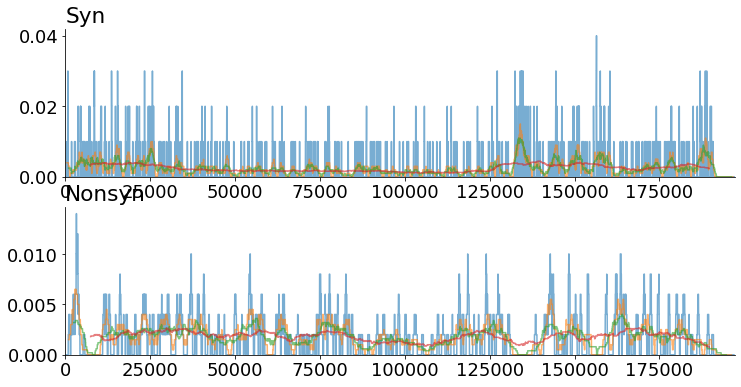

In [203]:
observed_synonymous = []
observed_nonsynonymous = []

with open("updated_2022-09-02/hMPXV1/Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["apobec"] == "True":
            if row["mutation_category"] == "nonsynonymous":
                observed_nonsynonymous.append(int(row["site"]))
            elif row["mutation_category"] in ["synonymous","intergenic"]:
                observed_synonymous.append(int(row["site"]))
        

with open("updated_2022-09-02/B.1/B.1_2022-08-22.og.aln.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if not row["parent"]=="Node1":
            if row["apobec"] == "True" and row["mutation_category"] == "nonsynonymous":
                observed_nonsynonymous.append(int(row["site"]))
            elif row["apobec"] == "True" and row["mutation_category"] in ["synonymous","intergenic"]:
                observed_synonymous.append(int(row["site"]))
        
                
fig, (ax0,ax1) = plt.subplots(2,figsize=(12,6),facecolor='w',frameon=False)


apobec_synonymous = np.array([i in observed_synonymous for i in pos])
apobec_nonsynonymous = np.array([i in observed_nonsynonymous for i in pos])


for ws in [100, 1000, 2000, 15000]:
    w = np.ones(ws)/ws
    ax0.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_synonymous, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax0.spines[loc].set_visible(False) for loc in ['top','right']]
# ax0.legend(loc='best', bbox_to_anchor=(0.6, 0.1, 0.6, 1),frameon=False)

ax0.set_ylim(0)
ax0.set_xlim(0,197209)
ax0.set_title("Syn",loc="left")


for ws in [500, 2000, 5000, 15000]:
    w = np.ones(ws)/ws
    ax1.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_nonsynonymous, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax1.spines[loc].set_visible(False) for loc in ['top','right']]

ax1.set_ylim(0)
ax1.set_xlim(0,197209)
ax1.set_title("Nonsyn",loc="left")

plt.savefig("figures/apobec_syn_nonsyn.hmpxv1_and_b1.convolve.svg");
plt.savefig("figures/apobec_syn_nonsyn.hmpxv1_and_b1.convolve.png",bbox_inches='tight', 
               transparent=True);



In [26]:
#perform Kolmogorov-Smirnov test
ks_2samp(apobec_target,apobec_synonymous)

NameError: name 'apobec_synonymous' is not defined

In [ ]:
apobec_target

In [ ]:
ks_2samp(apobec_target,apobec_synonymous)

In [103]:
from scipy import stats


stats.kstest(stats.uniform.rvs(size=100, random_state=rng),
             apobec_target)

ValueError: array([False, False, False, ..., False, False, False]) cannot be used to seed a numpy.random.RandomState instance

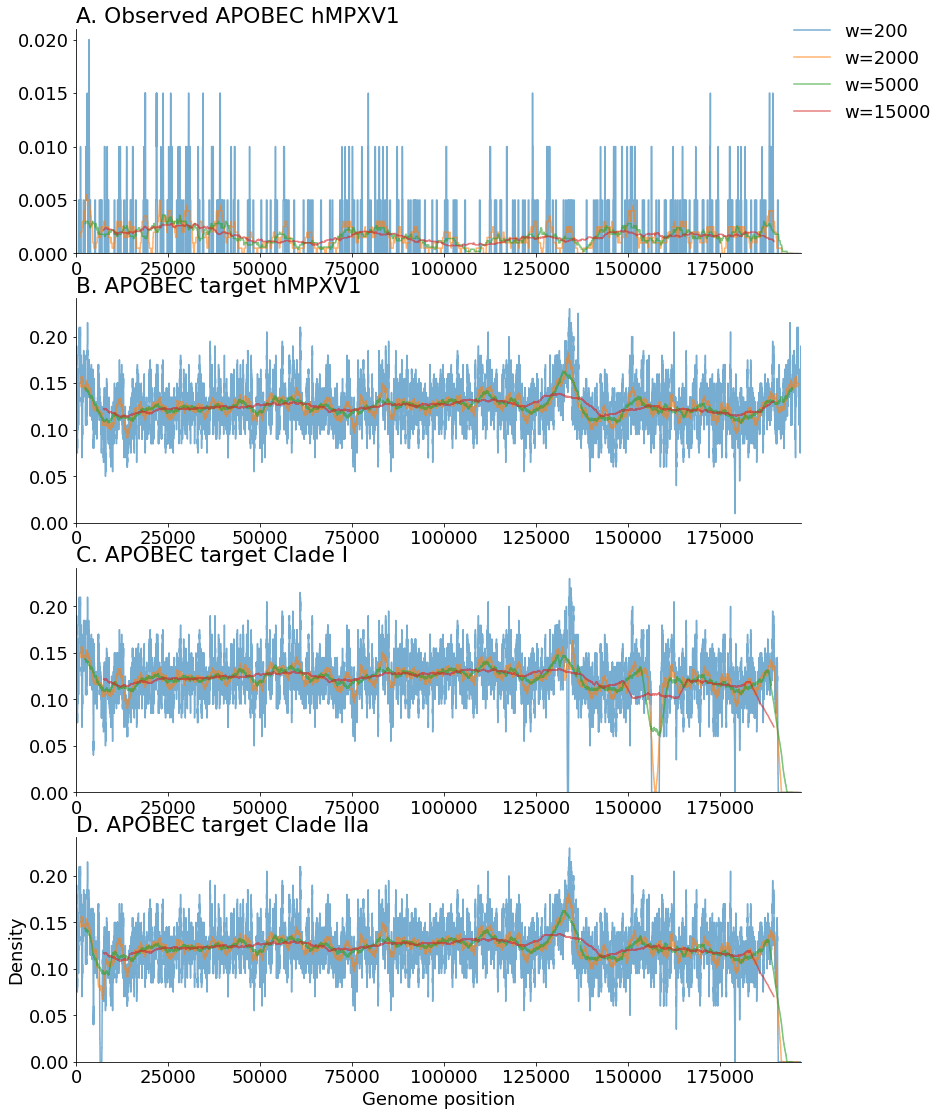

In [103]:
ref = str(SeqIO.read('/Users/s1680070/repositories/alignHPXV/squirrel/data/NC_063383.fasta', 'fasta').seq)
pos = np.arange(len(ref)-1)
apobec_target = np.array([ref[i:i+2]=='GA' or ref[i:i+2]=='TC' for i in pos])

fig, (ax0,ax1, ax2, ax3) = plt.subplots(4,figsize=(13,19),facecolor='w',frameon=False)

sites = []
with open("updated_2022-09-02/hMPXV1/Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
#         print(row)
        if row["dimer"] in ['GA',"TC"]:
            sites.append(int(row["site"]))
#             sites.append(int(row["site"]))
#             sites.append(int(row["site"]))
#             sites.append(int(row["site"]))

    
apobec_observed = np.array(np.array([i in sites for i in pos]))



for ws in [200, 2000, 5000, 15000]:
    w = np.ones(ws)/ws
    
    ax0.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_observed, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax0.spines[loc].set_visible(False) for loc in ['top','right']]
ax0.legend(loc='best', bbox_to_anchor=(0.6, 0.1, 0.6, 1),frameon=False)

ax0.set_ylim(0)
ax0.set_xlim(0,197209)
ax0.set_title("A. Observed APOBEC hMPXV1",loc="left")


for ws in [200, 2000, 5000, 15000]:
    w = np.ones(ws)/ws
    ax1.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_target, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax1.spines[loc].set_visible(False) for loc in ['top','right']]
# ax1.legend(loc='best', bbox_to_anchor=(0.6, 0.1, 0.6, 1),frameon=False)

ax1.set_ylim(0)
ax1.set_xlim(0,197209)
ax1.set_title("B. APOBEC target hMPXV1",loc="left")

seq1 = ""
for record in SeqIO.parse("reconstruction_clades1-3/clade1.aln.fasta","fasta"):
    if "DQ011154" in record.id:
        seq1 = str(record.seq)
pos = np.arange(len(seq1)-1)
apobec_target = np.array([seq1[i:i+2]=='GA' or seq1[i:i+2]=='TC' for i in pos])

for ws in [200, 2000, 5000, 15000]:
    w = np.ones(ws)/ws
    ax2.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_target, w, mode='valid'), label=f'w={ws}',alpha=0.6)
[ax2.spines[loc].set_visible(False) for loc in ['top','right']]
# ax2.legend(loc='best', bbox_to_anchor=(0.6, 0.1, 0.6, 1),frameon=False)
# ax2.xlabel("Genome position")
# ax2.ylabel("Density")

ax2.set_ylim(0)
ax2.set_xlim(0,197209)
ax2.set_title("C. APOBEC target Clade I",loc="left")


seq2 = ""
for record in SeqIO.parse("reconstruction_clades1-3/clade2.aln.fasta","fasta"):
    if "KP849470" in record.id:
        seq2 = str(record.seq)
pos = np.arange(len(seq2)-1)
apobec_target = np.array([seq2[i:i+2]=='GA' or seq2[i:i+2]=='TC' for i in pos])

for ws in [200, 2000, 5000, 15000]:
    w = np.ones(ws)/ws
    ax3.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_target, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax3.spines[loc].set_visible(False) for loc in ['top','right']]
# ax3.legend(loc='best', bbox_to_anchor=(0.6, 0.1, 0.6, 1),frameon=False)
# ax3.("Genome position")
# ax3.ylabel("Density")

ax3.set_ylim(0)
ax3.set_xlim(0,197209)
ax3.set_title("D. APOBEC target Clade IIa",loc="left")


plt.xlabel("Genome position")
plt.ylabel("Density")

plt.savefig("figures/apobec_target.2022-08-23.convolve.svg");
plt.savefig("figures/apobec_target.2022-08-23.convolve.png",bbox_inches='tight', 
               transparent=True);


In [99]:
np.convolve(apobec_observed, apobec_target,"valid")

array([ True])

In [71]:
b1_homoplasies = {'63147': 3, '5375': 2, '70190': 2, '63811': 2, '133103': 2, '74360': 2, '147168': 1, '61253': 1, '157527': 1, '44220': 1, '55133': 1, '100182': 1, '64426': 1, '150087': 1, '77807': 1, '25644': 1, '190668': 1, '6999': 1, '33103': 1, '123397': 1, '156469': 1, '94798': 1, '38937': 1, '32627': 1, '156429': 1, '103240': 1, '182189': 1, '181495': 1, '143074': 1, '132625': 1, '98456': 1, '102694': 1, '133867': 1, '32715': 1, '18133': 1, '133104': 1, '14611': 1, '49892': 1, '52752': 1, '170698': 1, '10484': 1}


b1_homoplasies = sorted([int(i) for i in list(b1_homoplasies)])
print(b1_homoplasies)
rows = []
with open("updated_2022-08-24_B.1/new_mask/B.1_2022-08-22.og.aln.fasta.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if int(row["site"]) in b1_homoplasies:
            rows.append(row)
            
for row in sorted(rows, key = lambda x: int(x["site"]) ):
    print(row["site"],'\t', row["snp"],'\t',row["dimer"], '\t',row["parent"],'\t',row["child"])


[5375, 6999, 10484, 14611, 18133, 25644, 32627, 32715, 33103, 38937, 44220, 49892, 52752, 55133, 61253, 63147, 63811, 64426, 70190, 74360, 77807, 94798, 98456, 100182, 102694, 103240, 123397, 132625, 133103, 133104, 133867, 143074, 147168, 150087, 156429, 156469, 157527, 170698, 181495, 182189, 190668]
5375 	 G->A 	 GC 	 Node73 	 Node74
5375 	 G->A 	 GC 	 Node66 	 OP184765|MpxV/human/USA/UW-WA-0062/2022|USA|2022-07
5375 	 G->A 	 GC 	 Node2 	 OP257247|MpxV/human/USA/UW-WA-0070/2022|USA|2022-08
6999 	 C->T 	 TC 	 Node66 	 ON755239|MPXV/Germany/2022/RKI033|Germany|2022-06
6999 	 C->T 	 TC 	 Node159 	 ON853656|MPXV/Germany/2022/RKI070|Germany|2022-06
10484 	 C->T 	 TC 	 Node131 	 OP171925|MPXV22/human/USA-NE-75|USA|2022-07-25
10484 	 C->T 	 TC 	 Node2 	 ON843168|Monkeypox/PT0032/2022|Portugal|2022-05-26
14611 	 G->A 	 GA 	 Node578 	 Node583
14611 	 G->A 	 GA 	 Node2 	 Node468
18133 	 C->T 	 TC 	 Node2 	 Node452
18133 	 C->T 	 TC 	 Node536 	 OP055809|MpxV/human/USA/UW-WA-0023/2022|USA|2022-

In [74]:
children = collections.defaultdict(list)
parents = collections.defaultdict(list)
for row in rows:
    parents[row["parent"]].append(row)
    children[row["child"]].append(row)
    
for parent in parents:
    if parent in children:
        print(parent)
        parent_rows = parents[parent]
        for row in parent_rows:
            print("Parent",row["site"],row["parent"],row["child"],row["snp"])
        child_rows = children[parent]
        for row in child_rows:
            print("Child",row["site"],row["parent"],row["child"],row["snp"])
        print("\n")

Node344
Parent 100182 Node344 OP169345|MpxV/human/USA/UW-WA-0052/2022|USA|2022-07 G->A
Parent 64426 Node344 Node345 C->T
Child 55133 Node343 Node344 G->A
Child 55133 Node343 Node344 G->A


Node73
Parent 55133 Node73 OP257243|MpxV/human/USA/UW-WA-0063/2022|USA|2022-08 G->A
Parent 55133 Node73 OP257243|MpxV/human/USA/UW-WA-0063/2022|USA|2022-08 G->A
Parent 5375 Node73 Node74 G->A
Child 100182 Node66 Node73 G->A


Node89
Parent 61253 Node89 ON929067|MPXV/Germany/2022/RKI109|Germany|2022-07 G->A
Child 147168 Node81 Node89 T->C


Node80
Parent 61253 Node80 Node91 G->A
Child 147168 Node66 Node80 C->T


Node91
Parent 44220 Node91 OP205127|MPXV_UK_2022_9000178|United_Kingdom|2022-06-27 C->T
Child 61253 Node80 Node91 G->A


Node102
Parent 150087 Node102 OP215279|MPXV/Germany/2022/RKI260|Germany|2022-08 G->A
Parent 156429 Node102 OP215279|MPXV/Germany/2022/RKI260|Germany|2022-08 C->T
Child 157527 Node95 Node102 T->C


Node536
Parent 18133 Node536 OP055809|MpxV/human/USA/UW-WA-0023/2022|USA|2022-

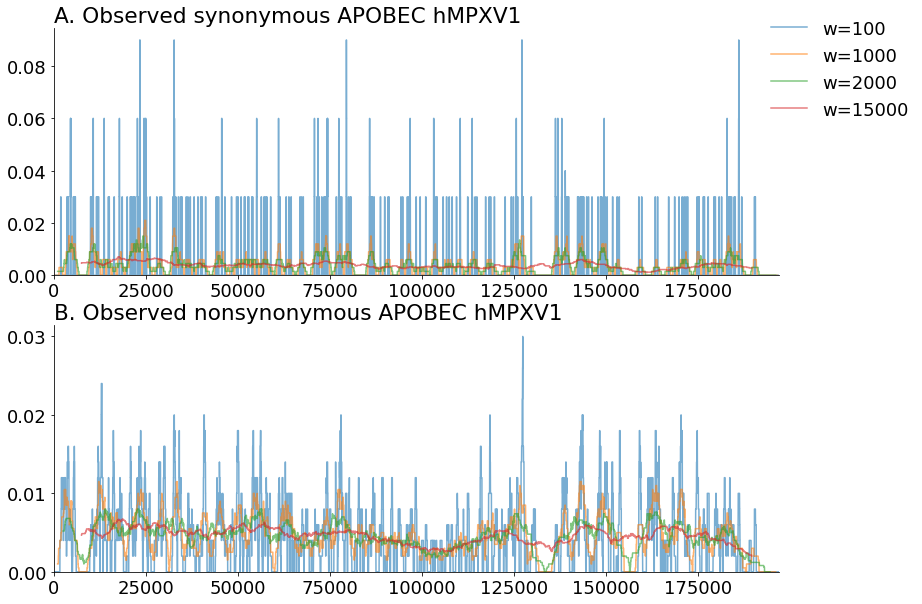

In [61]:
ref = str(SeqIO.read('/Users/s1680070/repositories/alignHPXV/squirrel/data/NC_063383.fasta', 'fasta').seq)
pos = np.arange(len(ref)-1)
synsites = []
nonsynsites = []
with open("updated_2022-08-24_B.1/with_oog/B.1_2022-08-22.og.aln.fasta.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        
        if row["mutation_category"] == "synonymous":
            synsites.append(int(row["site"]))
        elif row["mutation_category"]== "nonsynonymous":
            nonsynsites.append(int(row["site"]))

y1 = []
for site in synsites:
    y1.append(1)
    
y2 = []
for site in nonsynsites:
    y2.append(1)



pos = np.arange(len(ref)-1)

fig, (ax0,ax1) = plt.subplots(2,figsize=(13,10),facecolor='w',frameon=False)


apobec_synonymous = []
for i in pos:
    if i+1 in synsites or i+2 in synsites or i in synsites:
        apobec_synonymous.append(True)
    else:
        apobec_synonymous.append(False)
apobec_synonymous = np.array(apobec_synonymous)


apobec_nonsynonymous = []
for i in pos:
    if i+1 in synsites or i+2 in nonsynsites or i in nonsynsites:
        apobec_nonsynonymous.append(True)
    else:
        apobec_nonsynonymous.append(False)
apobec_nonsynonymous = np.array(apobec_nonsynonymous)



for ws in [100, 1000, 2000, 15000]:
    w = np.ones(ws)/ws
    ax0.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_synonymous, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax0.spines[loc].set_visible(False) for loc in ['top','right']]
ax0.legend(loc='best', bbox_to_anchor=(0.6, 0.1, 0.6, 1),frameon=False)

ax0.set_ylim(0)
ax0.set_xlim(0,197209)
ax0.set_title("A. Observed synonymous APOBEC hMPXV1",loc="left")


for ws in [500, 2000, 5000, 15000]:
    w = np.ones(ws)/ws
    ax1.plot(np.convolve(pos, w, mode='valid'), np.convolve(apobec_nonsynonymous, w, mode='valid'), label=f'w={ws}',alpha=0.6)

[ax1.spines[loc].set_visible(False) for loc in ['top','right']]

ax1.set_ylim(0)
ax1.set_xlim(0,197209)
ax1.set_title("B. Observed nonsynonymous APOBEC hMPXV1",loc="left")

plt.savefig("figures/apobec_syn_nonsyn.2022-08-24.convolve.svg");
plt.savefig("figures/apobec_syn_nonsyn.2022-08-24.convolve.png",bbox_inches='tight', 
               transparent=True);



In [ ]:

directory = "updated_2022-09-02/"
tree = "Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree"
alignment="Clade_IIb_2022-08-22_with_gisaid.aln.fasta"
run_full_analysis(directory, alignment, tree)

In [149]:
names = []
for record in SeqIO.parse("updated_2022-09-02/B.1/B.1_2022-08-22.og.aln.fasta","fasta"):
    
    recordid = record.id.split("|")[0]
    names.append(recordid)
print(len(names))


c = 0
alignment_records = {}
for record in SeqIO.parse("download_2022-10-28/sequence.gb","genbank"):
    cleanid = record.id.split(".")[0] 
    if cleanid in names:
        alignment_records[cleanid] = record
        
        c +=1 
print(c)

769
624


In [171]:
author_dict = collections.defaultdict(list)
institute_dict = {}
for record in alignment_records:
    i = alignment_records[record].annotations["references"][0]
    author_dict[i.authors].append(record) 
    institute_dict[i.authors] = i.journal
    
    
    
not_found = []
for i in names:
    if i not in alignment_records:
        not_found.append(i)

In [172]:
from Bio import Entrez
Entrez.email = "aine.otoole@ed.ac.uk"



records = []
for query in not_found:
    handle = Entrez.efetch(db="nucleotide", id=query, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    print(record.id)
    handle.close()
    records.append(record)

OP245306.1
OP245307.1
OP245308.1
OP245309.1
OP245310.2
OP245311.1
OP245312.1
OP245313.1
OP245314.1
OP245315.1
OP245316.1
OP245317.1
OP245318.1
OP245319.1
OP245320.1
OP245321.1
OP245322.1
OP245323.1
OP245324.1
OP245325.1
OP245326.1
OP245327.1
OP245328.1
OP245329.1
OP245330.1
OP245331.1
OP245332.1
OP245333.1
OP245334.1
OP245335.1
OP245336.1
OP245337.1
OP245338.1
OP245339.1
OP245340.1
OP245341.1
OP245342.1
OP245343.1
OP245344.2
OP245345.1
OP245346.1
OP245347.1
OP245348.1
OP245349.1
OP245350.1
OP245351.2
OP245352.2
OP245353.1
OP245354.1
OP245355.1
OP245356.1
OP245357.1
OP245358.1
OP245359.1
OP245360.1
OP245361.1
OX261748.1
OX261749.1
OP160532.1
OP133004.1
OP133005.1
OP133006.1
OP133007.1
OX248696.1
ON918611.1
ON927248.1
OP019275.1
OP019276.1
OP019277.1
ON959143.1
ON911481.2
ON880419.1
ON880420.1
ON880421.1
ON880422.1
ON872184.1
ON838939.1
ON838940.1
ON843163.1
ON843164.1
ON843165.1
ON843166.1
ON843167.1
ON843168.1
ON843169.1
ON843170.1
ON843171.1
ON843172.1
ON843173.1
ON843174.1
ON843175.1

HTTPError: HTTP Error 400: Bad Request

In [175]:
for record in records:
    i = record.annotations["references"][0]
    author_dict[i.authors].append(record.id) 
    institute_dict[i.authors] = i.journal
    print(i.journal, record.id)

Submitted (12-AUG-2022) Department of Infectious Diseases, National Institute of Health Doutor Ricardo Jorge, Portugal (INSA), Av. Padre Cruz, Lisbon 1649-016, Portugal OP245306.1
Submitted (12-AUG-2022) Department of Infectious Diseases, National Institute of Health Doutor Ricardo Jorge, Portugal (INSA), Av. Padre Cruz, Lisbon 1649-016, Portugal OP245307.1
Submitted (12-AUG-2022) Department of Infectious Diseases, National Institute of Health Doutor Ricardo Jorge, Portugal (INSA), Av. Padre Cruz, Lisbon 1649-016, Portugal OP245308.1
Submitted (12-AUG-2022) Department of Infectious Diseases, National Institute of Health Doutor Ricardo Jorge, Portugal (INSA), Av. Padre Cruz, Lisbon 1649-016, Portugal OP245309.1
Submitted (12-AUG-2022) Department of Infectious Diseases, National Institute of Health Doutor Ricardo Jorge, Portugal (INSA), Av. Padre Cruz, Lisbon 1649-016, Portugal OP245310.2
Submitted (12-AUG-2022) Department of Infectious Diseases, National Institute of Health Doutor Ricar

In [177]:
total_in_table = 0
with open("download_2022-10-28/sequence_metadata.tsv","w") as fw:
    fw.write("Authors\tInstitute\tAccession numbers\n")
    for i in author_dict:
        fw.write(f"{i}\t{institute_dict[i]}\t{';'.join(author_dict[i])}\n")
        total_in_table += len(author_dict[i])
print(total_in_table)

769


In [185]:
author_map = collections.defaultdict(list)
total_in_table = 0
for i in author_dict:
    author_map[i.split(",")[0]].append(i)
    
with open("download_2022-10-28/sequence_metadata.tsv","w") as fw:
    fw.write("Authors\tInstitute\tAccession numbers\n")
    for i in author_map:
        authors = sorted(author_map[i], key= lambda x : len(x), reverse=True)
        accessions = []
        institute = ""
        for j in author_map[i]:
            if institute_dict[j] != "Unpublished":
                institute = institute_dict[j].split(")")[1].lstrip(" ")
            for acc in author_dict[j]:
                accessions.append(acc)
                total_in_table+=1
        print(i, len(author_map[i]), authors[0])
        print(accessions)
        fw.write(f"{authors[0]}\t{institute}\t{';'.join(accessions)}\n")
    
    
    
print(total_in_table)

Zakotnik 2 Zakotnik,S., Vlaj,D., Suljic,A., Zorec,T.M., Skubic,C., Rozman,D., Korva,M., Poljak,M. and Avsic Zupanc,T.
['ON609725', 'ON631241', 'ON754987', 'ON754986', 'ON754985', 'ON754984', 'ON838178']
Groves 3 Groves,N., Osman,K.L., Lewandowski,K.S., Pullan,S.T., Carter,D.P., Crook,J.M., Myers,R., Vipond,R. and Chand,M.
['OP205140', 'OP205139', 'OP205138', 'OP205137', 'OP205136', 'OP205135', 'OP205134', 'OP205133', 'OP205132', 'OP205131', 'OP205130', 'OP205129', 'OP205128', 'OP205127', 'OP205126', 'OP205125', 'OP205124', 'OP205123', 'OP205122', 'OP205121', 'OP205120', 'OP205119', 'OP205118', 'OP205117', 'OP205116', 'OP205115', 'OP205114', 'OP205113', 'OP205112', 'OP205111', 'OP205110', 'OP205109', 'OP205108', 'OP205107', 'OP205106', 'OP205105', 'OP205104', 'OP205103', 'OP205102', 'OP205101', 'OP205100', 'OP205099', 'OP205098', 'OP205097', 'OP205096', 'OP205095', 'OP205094', 'OP205093', 'OP205092', 'OP205091', 'OP205090', 'OP205089', 'OP205088', 'OP205087', 'OP205086', 'OP205085', 'OP

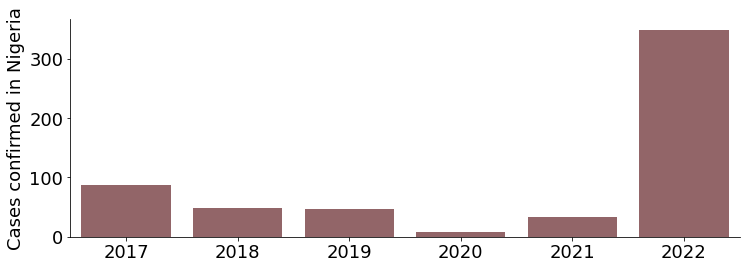

In [190]:
count = [88, 49, 47, 8, 34, 349]
year = [2017,2018,2019,2020,2021,2022]


fig,ax= plt.subplots(figsize=(12,4),facecolor='w',frameon=False)
sns.barplot( x=year, y=count,color="#995E62")

[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.ylabel("Cases confirmed in Nigeria")
    
    
plt.savefig("figures/confirmed_cases.svg");


plt.show();